<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#[Re]-A-common-representation-of-time-across-visual-and-auditory-modalities" data-toc-modified-id="[Re]-A-common-representation-of-time-across-visual-and-auditory-modalities-0"><span class="toc-item-num">0&nbsp;&nbsp;</span>[Re] <a href="../docs/a-common-representation.pdf" target="_blank">A common representation of time across visual and auditory modalities</a></a></span></li><li><span><a href="#Abstract-(text)" data-toc-modified-id="Abstract-(text)-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Abstract (text)</a></span></li><li><span><a href="#Imports-Packages-(code)" data-toc-modified-id="Imports-Packages-(code)-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Imports Packages (code)</a></span></li><li><span><a href="#Introduction:-(text)" data-toc-modified-id="Introduction:-(text)-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Introduction: (text)</a></span></li><li><span><a href="#Materials-and-methods-(text-and-code)" data-toc-modified-id="Materials-and-methods-(text-and-code)-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Materials and methods (text and code)</a></span><ul class="toc-item"><li><span><a href="#Participants-(text)" data-toc-modified-id="Participants-(text)-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Participants (text)</a></span><ul class="toc-item"><li><span><a href="#Set-the-number-of-volunteers-(code)" data-toc-modified-id="Set-the-number-of-volunteers-(code)-4.1.1"><span class="toc-item-num">4.1.1&nbsp;&nbsp;</span>Set the number of volunteers (code)</a></span></li><li><span><a href="#Download-Data-(code)" data-toc-modified-id="Download-Data-(code)-4.1.2"><span class="toc-item-num">4.1.2&nbsp;&nbsp;</span>Download Data (code)</a></span></li><li><span><a href="#Reading-process-(code)" data-toc-modified-id="Reading-process-(code)-4.1.3"><span class="toc-item-num">4.1.3&nbsp;&nbsp;</span>Reading process (code)</a></span><ul class="toc-item"><li><span><a href="#Checking-the-shape-in-arrays" data-toc-modified-id="Checking-the-shape-in-arrays-4.1.3.1"><span class="toc-item-num">4.1.3.1&nbsp;&nbsp;</span>Checking the shape in arrays</a></span></li></ul></li></ul></li><li><span><a href="#Experimental-design-(text)" data-toc-modified-id="Experimental-design-(text)-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Experimental design (text)</a></span></li><li><span><a href="#Behavioural-analysis-(text)" data-toc-modified-id="Behavioural-analysis-(text)-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>Behavioural analysis (text)</a></span></li><li><span><a href="#EEG-recordings-and-pre-processing-(text-and-code)" data-toc-modified-id="EEG-recordings-and-pre-processing-(text-and-code)-4.4"><span class="toc-item-num">4.4&nbsp;&nbsp;</span>EEG recordings and pre-processing (text and code)</a></span><ul class="toc-item"><li><span><a href="#Frequency-Information-(code)" data-toc-modified-id="Frequency-Information-(code)-4.4.1"><span class="toc-item-num">4.4.1&nbsp;&nbsp;</span>Frequency Information (code)</a></span></li></ul></li><li><span><a href="#Multivariate-pattern-analysis-–-MVPA-(text)" data-toc-modified-id="Multivariate-pattern-analysis-–-MVPA-(text)-4.5"><span class="toc-item-num">4.5&nbsp;&nbsp;</span>Multivariate pattern analysis – MVPA (text)</a></span><ul class="toc-item"><li><span><a href="#Similarity-between-different-trials-and-modalities-(text)" data-toc-modified-id="Similarity-between-different-trials-and-modalities-(text)-4.5.1"><span class="toc-item-num">4.5.1&nbsp;&nbsp;</span>Similarity between different trials and modalities (text)</a></span></li><li><span><a href="#Decoding-the-elapsed-interval-(text)" data-toc-modified-id="Decoding-the-elapsed-interval-(text)-4.5.2"><span class="toc-item-num">4.5.2&nbsp;&nbsp;</span>Decoding the elapsed interval (text)</a></span><ul class="toc-item"><li><span><a href="#Decoding-Code-(code)" data-toc-modified-id="Decoding-Code-(code)-4.5.2.1"><span class="toc-item-num">4.5.2.1&nbsp;&nbsp;</span>Decoding Code (code)</a></span></li><li><span><a href="#Joining-groups-and-X-(code)" data-toc-modified-id="Joining-groups-and-X-(code)-4.5.2.2"><span class="toc-item-num">4.5.2.2&nbsp;&nbsp;</span>Joining groups and X (code)</a></span></li><li><span><a href="#Within-modality-classification-(text)" data-toc-modified-id="Within-modality-classification-(text)-4.5.2.3"><span class="toc-item-num">4.5.2.3&nbsp;&nbsp;</span>Within modality classification (text)</a></span></li><li><span><a href="#Between-modalities-classification-(text)" data-toc-modified-id="Between-modalities-classification-(text)-4.5.2.4"><span class="toc-item-num">4.5.2.4&nbsp;&nbsp;</span>Between modalities classification (text)</a></span></li></ul></li><li><span><a href="#Correlation-of-decoding-and-behaviour-(text)" data-toc-modified-id="Correlation-of-decoding-and-behaviour-(text)-4.5.3"><span class="toc-item-num">4.5.3&nbsp;&nbsp;</span>Correlation of decoding and behaviour (text)</a></span></li></ul></li><li><span><a href="#Parei-Aqui-de-escrever/organizar-o-texto-quando-vi-que-o-resultado-não-estava-dando-certo!-" data-toc-modified-id="Parei-Aqui-de-escrever/organizar-o-texto-quando-vi-que-o-resultado-não-estava-dando-certo!--4.6"><span class="toc-item-num">4.6&nbsp;&nbsp;</span>Parei Aqui de escrever/organizar o texto quando vi que o resultado não estava dando certo! </a></span></li></ul></li><li><span><a href="#Classification-process" data-toc-modified-id="Classification-process-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Classification process</a></span><ul class="toc-item"><li><span><a href="#With-PCA-processing" data-toc-modified-id="With-PCA-processing-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>With PCA processing</a></span></li></ul></li><li><span><a href="#Balancelamento-das-classes" data-toc-modified-id="Balancelamento-das-classes-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Balancelamento das classes</a></span><ul class="toc-item"><li><span><a href="#Distribuição-das-classes" data-toc-modified-id="Distribuição-das-classes-6.1"><span class="toc-item-num">6.1&nbsp;&nbsp;</span>Distribuição das classes</a></span></li></ul></li><li><span><a href="#Checagem-do-rótulos-às-médias" data-toc-modified-id="Checagem-do-rótulos-às-médias-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Checagem do rótulos às médias</a></span><ul class="toc-item"><li><span><a href="#Inspeção-por-permutação" data-toc-modified-id="Inspeção-por-permutação-7.1"><span class="toc-item-num">7.1&nbsp;&nbsp;</span>Inspeção por permutação</a></span></li></ul></li></ul></div>

# [Re] [A common representation of time across visual and auditory modalities](../docs/a-common-representation.pdf)

Louise C.Barne<sup>1</sup>, João R. Sato<sup>1</sup>, Raphael Y. de Camargo<sup>1</sup>,Peter M. E. Claessens<sup>1</sup>, Marcelo S. Caetano<sup>1</sup>, André M. Cravo<sup>1*</sup>

> <sup>1</sup> Centro de Matemática, Computação e Cognição, Universidade Federal do ABC (UFABC), Rua Arcturus, 03. Bairro Jardim Antares, São Bernardo do Campo, CEP 09606-070 SP, Brazil

*andre.cravo@ufabc.edu.br

# Abstract (text)

Humans' and non-human animals' ability to process time on the scale of milliseconds and seconds is essential for adaptive behaviour. A central question of how brains keep track of time is how specific temporal information across different sensory modalities is. In the present study, we show that encoding of temporal intervals in auditory and visual modalities are qualitatively similar. Human participants were instructed to reproduce intervals in the range from 750 ms to 1500 ms marked by auditory or visual stimuli. Our behavioural results suggest that, although participants were more accurate in reproducing intervals marked by auditory stimuli, there was a strong correlation in performance between modalities. Using multivariate pattern analysis in scalp EEG, we show that activity during late periods of the intervals was similar within and between modalities. Critically, we show that a multivariate pattern classifier was able to accurately predict the elapsed interval, even when trained on an interval marked by a stimulus of a different sensory modality. Taken together, our results suggest that, while there are differences in the processing of intervals marked by auditory and visual stimuli, they also share a common neural representation.

Keywords: Time perception, Multivariate pattern analysis, EEG, Vision, Audition

---

Responsible for the reproduction of the results: [Bruno Aristimunha](https://github.com/bruAristimunha).

The goals in the work is:
    - Find common representations of different sensory modalities;
    - Improve the sensitivity of subsequent MVPA analyzes
    - Make a reproducible report of the results previously reported;


Advisors: [Raphael Y. de Camargo](https://rycamargo.wixsite.com/home) e [André Cravo](https://bv.fapesp.br/pt/pesquisador/65843/andre-mascioli-cravo).

***

This work follows the structure below: 

# Imports Packages (code)
Imports packages which are used by jupyter paper

In [1]:
from sklearn.inspection import permutation_importance
from sklearn.model_selection import cross_val_score, train_test_split, LeaveOneOut
from tqdm.autonotebook import tqdm
from sklearn import preprocessing
from sklearn.metrics import classification_report,cohen_kappa_score
from sklearn.naive_bayes import GaussianNB
from sklearn.decomposition import PCA
from os.path import isfile, join
from os import listdir

import sys
import doctest
import matplotlib
import seaborn as sns
import scipy.io as sio
import scipy as sc
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
sns.set()

plt.style.use('seaborn-white')

sys.path.append("../src/data")

/home/brain/anaconda3/envs/tf-gpu/lib/python3.6/site-packages/ipykernel_launcher.py:3: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  This is separate from the ipykernel package so we can avoid doing imports until


In [2]:
from myMNE import makeMNE

# Introduction: (text)

The ability to estimate time is essential for humans and non-human animals to interact with their environment ([Buhusi and Meck, 2005](https://www.sciencedirect.com/science/article/pii/S0028393218304913%23bib5&sa=D&ust=1580959905399000),[ ](https://www.sciencedirect.com/science/article/pii/S0028393218304913%23bib27&sa=D&ust=1580959905399000)[Mauk and Buonomano, 2004](https://www.sciencedirect.com/science/article/pii/S0028393218304913%23bib27&sa=D&ust=1580959905400000),[ ](https://www.sciencedirect.com/science/article/pii/S0028393218304913%23bib28&sa=D&ust=1580959905400000)[Merchant et al., 2013a](https://www.sciencedirect.com/science/article/pii/S0028393218304913%23bib28&sa=D&ust=1580959905401000)). Intervals in the range of hundreds of milliseconds to seconds are critical for sensory and motor processing, learning, and cognition ([Buhusi and Meck, 2005](https://www.sciencedirect.com/science/article/pii/S0028393218304913%23bib5&sa=D&ust=1580959905401000),[ ](https://www.sciencedirect.com/science/article/pii/S0028393218304913%23bib27&sa=D&ust=1580959905402000)[Mauk and Buonomano, 2004](https://www.sciencedirect.com/science/article/pii/S0028393218304913%23bib27&sa=D&ust=1580959905402000),[ ](https://www.sciencedirect.com/science/article/pii/S0028393218304913%23bib28&sa=D&ust=1580959905403000)[Merchant et al., 2013a](https://www.sciencedirect.com/science/article/pii/S0028393218304913%23bib28&sa=D&ust=1580959905403000)). However, the mechanisms underlying temporal processing in this range are still largely discussed. A central unanswered question is whether temporal processing depends on dedicated or intrinsic circuits ([Ivry and Schlerf, 2008](https://www.sciencedirect.com/science/article/pii/S0028393218304913%23bib16&sa=D&ust=1580959905404000)). Dedicated models propose that temporal perception depends on central specialised mechanisms, as an internal clock, that create a unified perception of time ([Ivry and Schlerf, 2008](https://www.sciencedirect.com/science/article/pii/S0028393218304913%23bib16&sa=D&ust=1580959905404000)). This class of models can account for behavioural findings such as correlations in performance for some temporal tasks ([Keele et al., 1985](https://www.sciencedirect.com/science/article/pii/S0028393218304913%23bib20&sa=D&ust=1580959905405000)) and the observation that learning to discriminate a temporal interval in one sensory modality can sometimes be transferred to other modalities ([Bueti and Buonomano, 2014](https://www.sciencedirect.com/science/article/pii/S0028393218304913%23bib4&sa=D&ust=1580959905405000)).

Intrinsic models of time propose that a variety of neural circuits distributed across the brain are capable of temporal processing. One of the most known examples is the state-dependent network - SDN ([Mauk and Buonomano, 2004](https://www.sciencedirect.com/science/article/pii/S0028393218304913%23bib27&sa=D&ust=1580959905406000)). Within this framework, neural circuits can take advantage of the natural temporal evolution of its states to keep track of time ([Mauk and Buonomano, 2004](https://www.sciencedirect.com/science/article/pii/S0028393218304913%23bib27&sa=D&ust=1580959905407000)). One of the main advantages of such models is that they can explain the known differences of temporal processing across sensory modalities ([van Wassenhove, 2009](https://www.sciencedirect.com/science/article/pii/S0028393218304913%23bib38&sa=D&ust=1580959905407000)) and that learning a specific interval does not commonly improve temporal performance in other intervals ([Bueti and Buonomano, 2014](https://www.sciencedirect.com/science/article/pii/S0028393218304913%23bib4&sa=D&ust=1580959905408000)).

Given that both dedicated and intrinsic views can account for some results while not explaining others, there has been an increase in interest in hybrid models, according to which local task-dependent areas interact with a higher central timing system ([Merchant et al., 2013a](https://www.sciencedirect.com/science/article/pii/S0028393218304913%23bib28&sa=D&ust=1580959905409000),[ ](https://www.sciencedirect.com/science/article/pii/S0028393218304913%23bib39&sa=D&ust=1580959905409000)[Wiener et al., 2011](https://www.sciencedirect.com/science/article/pii/S0028393218304913%23bib39&sa=D&ust=1580959905410000)). The main advantage of hybrid models is that they can explain why performance in some timing tasks seems to be correlated across participants, while still exhibiting modality and task-related differences ([Merchant et al., 2008b](https://www.sciencedirect.com/science/article/pii/S0028393218304913%23bib33&sa=D&ust=1580959905410000),[ ](https://www.sciencedirect.com/science/article/pii/S0028393218304913%23bib32&sa=D&ust=1580959905411000)[Merchant et al., 2008a](https://www.sciencedirect.com/science/article/pii/S0028393218304913%23bib32&sa=D&ust=1580959905411000)).

In humans, studies that investigate these different models employ a variety of methods, such as behavioural, neuroimaging and neuropharmacological manipulations, on healthy participants and neurological patients ([Coull et al., 2011](https://www.sciencedirect.com/science/article/pii/S0028393218304913%23bib9&sa=D&ust=1580959905412000),[ ](https://www.sciencedirect.com/science/article/pii/S0028393218304913%23bib16&sa=D&ust=1580959905413000)[Ivry and Schlerf, 2008](https://www.sciencedirect.com/science/article/pii/S0028393218304913%23bib16&sa=D&ust=1580959905413000),[ ](https://www.sciencedirect.com/science/article/pii/S0028393218304913%23bib21&sa=D&ust=1580959905414000)[Kononowicz et al., 2016](https://www.sciencedirect.com/science/article/pii/S0028393218304913%23bib21&sa=D&ust=1580959905414000),[ ](https://www.sciencedirect.com/science/article/pii/S0028393218304913%23bib28&sa=D&ust=1580959905415000)[Merchant et al., 2013a](https://www.sciencedirect.com/science/article/pii/S0028393218304913%23bib28&sa=D&ust=1580959905415000),[ ](https://www.sciencedirect.com/science/article/pii/S0028393218304913%23bib39&sa=D&ust=1580959905416000)[Wiener et al., 2011](https://www.sciencedirect.com/science/article/pii/S0028393218304913%23bib39&sa=D&ust=1580959905416000)). Although the high temporal resolution of EEG should in principle be optimal to track neural processing during temporal tasks, the contribution of these methods has been controversial. One of the main difficulties is the absence of a clear electrophysiological correlate of temporal processing (for a recent review see ([Kononowicz et al., 2016](https://www.sciencedirect.com/science/article/pii/S0028393218304913%23bib21&sa=D&ust=1580959905417000))). This lack of electrophysiological markers makes it hard to judge, for example, whether temporal processing in different modalities share a common representation ([N'Diaye et al., 2004](https://www.sciencedirect.com/science/article/pii/S0028393218304913%23bib34&sa=D&ust=1580959905417000)).

In a recent study, we have shown that multivariate pattern analysis (MVPA) can reveal spatiotemporal dynamics of brain activity related to temporal processing ([Bueno et al., 2017](https://www.sciencedirect.com/science/article/pii/S0028393218304913%23bib3&sa=D&ust=1580959905418000)). Multivariate approaches can take advantage of small differences in the signal across electrodes that might not be detectable using classical EEG methods. These pattern recognition methods allow the assessment of whether brain states evoked by different tasks, stimuli and sensory modalities are qualitatively similar.

In the present study, we investigated whether encoding of temporal intervals in different sensory modalities is qualitatively similar. Our behavioural results suggest that, although participants are more accurate in reproducing intervals marked by auditory stimuli, there is a strong correlation over observers in performance between modalities. Critically, we show that a multivariate pattern classifier based on EEG activity can predict the elapsed interval, even when trained on an interval marked by a different sensory modality. Taken together, our results suggest that, while there are differences in the processing of intervals marked by auditory and visual stimuli, they also share a common neural representation.

---


# Materials and methods (text and code)

## Participants (text)

Twenty volunteers (age range, 18–30 years; 11 female) gave informed consent to participate in this study. All of them had normal or corrected-to-normal vision and were free from psychological or neurological diseases. The experimental protocol was approved by The Research Ethics Committee of the Federal University of ABC. All experiments were performed in accordance with the approved guidelines and regulations.

### Set the number of volunteers (code)

In [3]:
N_PEOPLE = 20

### Download Data (code)

The EEG data obtained from the experiment reported above and the meta-information are required for reproduction. These files have 2.1G GB and you do need them for all the analysis in the Jupyter Paper.

In [4]:
PATH_AUD = '../data/raw/aud'
PATH_VIS = '../data/raw/vis'
PATH_INFO = '../data/raw/info_'

### Reading process (code)

TO-DO: short text describing the functions

In [5]:
def files_in_path(path):
    return [path+"/"+f for f in listdir(path) if isfile(join(path, f))]

# Getting data from MNE strutuct
def data_from_mne(files):
    return np.array([file.get_data().T for file in files])

# List of Files contained in the folder with path

path_file_aud = files_in_path(PATH_AUD)
path_file_vis = files_in_path(PATH_VIS)

# Reading files with the MNE library

files_aud = list(map(makeMNE, path_file_aud))
files_vis = list(map(makeMNE, path_file_vis))

# Getting data in numpy format
data_aud = data_from_mne(files_aud)
data_vis = data_from_mne(files_vis)

In [6]:
CHANNEL_NAMES = files_aud[0].ch_names

#### Checking the shape in arrays

In [7]:
print("Data Aud with shape: {} (individual, raw, channels, trial)".format(data_aud.shape))
print("Data Vis with shape: {} (individual, raw, channels, trial)".format(data_vis.shape))

Data Aud with shape: (20, 539, 64, 240) (individual, raw, channels, trial)
Data Vis with shape: (20, 539, 64, 240) (individual, raw, channels, trial)


In [8]:
def get_bad_trials(file_name):
    import warnings
    warnings.filterwarnings("ignore")


    file = sio.loadmat(file_name,squeeze_me=True, struct_as_record=False)


    badtrials = lambda df : df['ft_data_auditory'].badtrials
    
    return badtrials(file)


In [9]:
bad_trials_aud = list(map(get_bad_trials, path_file_aud))
bad_trials_vis = list(map(get_bad_trials, path_file_vis))

In [10]:
df_bad_trials_aud = pd.DataFrame([bad_trials_aud],index=['Aud'])
df_bad_trials_vis = pd.DataFrame([bad_trials_vis],index=['Vis'])


## Experimental design (text)

The experiment consisted of a temporal reproduction task. The stimuli were presented using the Psychtoolbox v.3.0 package ([Brainard, 1997](https://www.sciencedirect.com/science/article/pii/S0028393218304913#bib2)) on a 20-in. CRT monitor with a vertical refresh rate of 60 Hz, placed 50 cm in front of the participant.

Each trial started with a fixation point that participants fixated throughout the trial. After a delay (1.5 s), two flashes or tones were presented, separated by a sample interval (measured between tone or flash onsets). After a random delay (1.5–2.5 s), volunteers were re-exposed to the same interval. After another random delay (1.5–2.5 s), a ready stimulus was presented to the participant, indicating the beginning of the reproduction task [Figure 1](Figure 1). Volunteers had to reproduce the exposed interval, initiated by the ready stimulus (RS) and ended by a stimulus caused by a button press (R1).

![Figure 1](../reports/figures/Figure_01_temporal_reproduction_task.jpg)
**Figure 1 | Temporal reproduction task.** (**A**) Sequence of events during a trial. Each trial consisted of two equal empty intervals (between 750 ms and 1500 ms), marked by two stimuli. In auditory blocks, the interval was marked by two brief tones (1000 Hz, 100 ms), while in visual blocks the interval was marked by two flashes (0.5° of visual angle, 100 ms). Participants were instructed to reproduce the interval at the end of each trial. .


In auditory blocks, the tones consisted of 1000 Hz tones (100 ms duration), while the ready and end stimuli consisted of 500 Hz tones. In visual blocks, the flashes that marked the interval consisted of yellow 0.5° of visual angle discs (100 ms duration), while the ready and end stimuli consisted of magenta flashes of the same size. No direct feedback was given.

The sample intervals ranged between 750 ms and 1500 ms and were uniformly distributed. Each block (visual or auditory) consisted of 120 trials. Half of the participants performed the visual block first, while the other half performed the auditory block first.

In [11]:
N_TRIALS = 120

## Behavioural analysis (text)

Events in which intervals were reproduced as longer than double the sample interval or shorter than half the sample interval were considered errors and excluded from further analyses. The proportion of errors was low for both modalities (auditory: $0.0042 \pm 0.0011$; maximum proportion of rejected trials per participant=$0.0167$; visual: $0.0092 \pm 0.0031$; maximum proportion of rejected trials per participant $= 0.0583$)

Similarly to previous studies ([Cicchini et al., 2012](), [Jazayeri and Shadlen, 2010]() ), the total error in the reproduction task was partitioned into two components: the average bias (BIAS) and the average variance ($\text{VAR}$). These two metrics are directly related to the overall mean squared error (MSE). To calculate these components, sample intervals were first binned into six equally sized bins and, for each bin, an estimate of both measures were calculated. The BIAS for each bin was calculated as the average difference between the reproduced interval and the sample intervals. The $\text{VAR}$ for each bin was calculated as the variance of the difference between reproduced and real intervals. The final estimate of the BIAS was calculated as the root mean square of the BIAS across bins and of the $\text{VAR}$ as the average $\text{VAR}$ across bins ([Jazayeri and Shadlen, 2010]()). For ease of interpretation and comparison with previous studies, the $\text{VAR}$ values were plotted using its square root $\sqrt{\text{VAR}}$.


We further calculated a regression index ($\text{RI}$) to index the tendency of reproduced intervals to regress towards the mean sample. This index was calculated as the difference in slope between the best linear fit on the reproduced interval and perfect performance ([Cicchini et al., 2012]()). This measure varies from $0$ (perfect performance) to $1$ (complete regression to the mean, after allowing for a constant bias). The same linear fit between real and reproduced intervals was used to calculate the indifference points for both modalities. This point refers to the physical interval where durations are reproduced veridically.

To analyse the scalar property of time, we computed the slope of the generalised Weber function ([García-Garibay et al., 2016](), [Getty, 1975](), [Ivry and Hazeltine, 1995]()). A linear regression between the variance of the reproduced intervals and the mean subjective duration squared was performed as follows: (1)


where $k$ is the slope that approximates the Weber fraction and $\sigma^2_{\text{indep}}$ is a constant representing the time-independent component of the variability. To account for the systematic bias found in the reproduced intervals, we used an approach similar to [García-Garibay et al. (2016)] in which

was computed based on the linear fit between real and reproduced intervals.

All measures were calculated separately for each participant and condition (auditory and visual). At the group level, comparisons between the calculated parameters were done using paired t-tests (two-sided). To investigate correlations across participants for all three measures, Pearson correlations were calculated between the values of each measure in visual and auditory conditions.



## EEG recordings and pre-processing (text and code)

EEG was recorded continuously from 64 ActiCap Electrodes (Brain Products) at 1000 Hz by a QuickAmp amplifier (Brain Products). All sites were referenced to FCz and grounded to AFz. The electrodes were positioned according to the International 10–10 system. Additional bipolar electrodes registered the electrooculogram (EOG).

EEG pre-processing was carried out using BrainVision Analyzer (Brain Products). All data were down-sampled to 250 Hz and re-referenced to the average activity across electrodes. For eye movement artefact rejection, an independent component analysis (ICA) was performed on filtered (Butterworth Zero Phase Filter between 0.05.05 Hz and 30 Hz) and segmented (−200 to 2000 ms relative to S1) data. For the ICA, epochs were baselined based on the average activity of the entire trial. Eye related components were identified by comparing individual ICA components with EOG channels and by visual inspection. The average proportion of rejected trials for each participant corresponded to 0.0613. For all further analyses, epochs were baseline corrected based on the period between −200 ms and 0 ms relative to S1 presentation.

### Frequency Information (code)

The data set was originally recorded in 1000 Hz and down-sampled to 250 Hz;

In [12]:
N_CHANNELS = 64
#N_CHANNELS = 62


ORIGINAL_FREQUENCY = 1000

DOWN_SAMPLED_FREQUENCY = 250

## Multivariate pattern analysis – MVPA (text)

### Similarity between different trials and modalities (text)


Not reproduced **yet**.

<!---
To calculate the similarity across trials we used a bootstrap approach. For each participant and comparison of interest, data from all intervals that lasted at least 1.125 s were divided into two groups of trials and averaged across trials per group ([Bueno et al., 2017]()). Then, for each time point, data from each split (two-row vectors with the averaged amplitude values of all 62 electrodes) were compared using a Pearson correlation. This procedure was repeated 5000 times for each participant and Fisher transformed coefficients were averaged across permutations for each participant and comparison of interest.

At the group level, EEG-analyses were implemented non-parametrically ([Maris and Oostenveld, 2007](), [Wolff et al., 2015]()) with sign-permutation tests. For each time-point, the Fisher transformed coefficients for a random half of the participants were multiplied by $-1$. The resulting distribution was used to calculate the p-value of the null-hypothesis that the mean value was equal to $0$. Cluster-based permutation tests were then used to correct for multiple comparisons across time using $5000$ permutations, with a cluster-forming threshold of p$<0.05$ ([Maris and Oostenveld, 2007]()). The sum of the values within a cluster was used as the cluster-level statistic. The significance threshold was set at p$<0.05$; all tests were one-sided.
-->

### Decoding the elapsed interval (text)

To investigate whether information about the elapsed interval could be decoded from activity across electrodes, we used a Naive Bayes classifier to perform a multiclass classification ([Grootswagers et al., 2017]()). For all classifications, activity from the last 125 ms of the elapsed interval (−125 ms to 0 relative to S2) was averaged for each electrode. Data for each exposure (E1 and E2) were analysed separately. Intervals were divided into six equally sized bins (125 ms each).



#### Decoding Code (code)


At this point we understand that:

> We should divide the exposures. Consulting the authors by definition in trial odd are the first exposure, and trial even the second exposure. For this we develop the functions `_exposure_1`, `_exposure_2`.
    

In [13]:
# Function to exposure separation:

def _exposure_1(data): 
    # Getting the first exposure.
    # [individual, raw, channels, trial]
    return data[::, ::, ::, 0:: 2]

def _exposure_2(data): 
    # Getting the second exposure.
    # [individual, raw, channels, trial]
    return data[::, ::, ::, 1:: 2]


In [14]:
# Function to exposure separation:

def _exposure_1_bad(df_bad_trials,type_name): 
    exposure_1_list = []
    for ind, person in df_bad_trials.T.iteritems():
        by_person = []
        for ind_b, bad in person.iteritems():
            if(not(isinstance(bad, int))):
                #import pdb;pdb.set_trace()
                by_person.append(np.divide((bad[ 0:: 2]),2.).astype(int))
            else:
                if(isinstance(bad, int)):
                    if(bad %2 == 0):
                        #print(bad)
                        by_person.append([int(bad/2)])
                    else:
                        by_person.append([])
                else:
                    if(bad == []):
                        by_person.append([])
        exposure_1_list.append(by_person)
    
    
    return pd.DataFrame(exposure_1_list, index=[type_name])

def _exposure_2_bad(df_bad_trials, type_name): 
    exposure_2_list = []
    for ind, person in df_bad_trials.T.iteritems():
        by_person = []
        for ind_b, bad in person.iteritems():
            if(not(isinstance(bad, int))):
                by_person.append(np.divide((bad[ 1:: 2]),2.).astype(int))
            else:
                if(isinstance(bad, int)):
                    if(bad %2 != 0):
                        #print(bad)
                        by_person.append([int(bad/2)])
                    else:
                        by_person.append([])
                else:
                    if(bad == []):
                        by_person.append([])
        exposure_2_list.append(by_person)

  
    return pd.DataFrame(exposure_2_list, index=[type_name])


In [15]:
## Splitting the exposures for all the individuals

aud_1 = _exposure_1(data_aud)

aud_2 = _exposure_2(data_aud) 

vis_1 = _exposure_1(data_vis)

vis_2 = _exposure_2(data_vis)

In [16]:
## Splitting the exposures for all the individuals

bad_aud_1 = _exposure_1_bad(df_bad_trials_aud, 'Aud')

bad_aud_2 = _exposure_2_bad(df_bad_trials_aud, 'Aud') 

bad_vis_1 = _exposure_1_bad(df_bad_trials_vis, 'Vis')

bad_vis_2 = _exposure_2_bad(df_bad_trials_vis, 'Vis')

In [17]:
bad_aud_1 = bad_aud_1.T.reset_index()
bad_aud_2 = bad_aud_2.T.reset_index()
bad_vis_1 = bad_vis_1.T.reset_index()
bad_vis_2 = bad_vis_2.T.reset_index()

In [18]:
clean_aud_1 = bad_aud_1.explode(column='Aud')
clean_aud_1.columns = ['people','trial']
clean_aud_1 = clean_aud_1.dropna()
clean_aud_1 = clean_aud_1.reset_index(drop=True)
clean_aud_1['bad_flag'] = True

clean_aud_2 = bad_aud_2.explode(column='Aud')
clean_aud_2.columns = ['people','trial']
clean_aud_2 = clean_aud_2.dropna()
clean_aud_2 = clean_aud_2.reset_index(drop=True)
clean_aud_2['bad_flag'] = True

clean_vis_1 = bad_vis_1.explode(column='Vis')
clean_vis_1.columns = ['people','trial']
clean_vis_1 = clean_vis_1.dropna()
clean_vis_1 = clean_vis_1.reset_index(drop=True)
clean_vis_1['bad_flag'] = True

clean_vis_2 = bad_vis_2.explode(column='Vis')
clean_vis_2.columns = ['people','trial']
clean_vis_2 = clean_vis_2.dropna()
clean_vis_2 = clean_vis_2.reset_index(drop=True)
clean_vis_2['bad_flag'] = True

> For each trial, we will get only the last $125$ ms before $S2$;

> The rest is discarded;

> We must evaluate the mean value in the last $125$ ms.

With the sampled frequency of $250$ Hz, there will be one point every $4$ milliseconds. If we want $ 125 $ milliseconds just divide it and take the ratio $\frac{125 \text{ms}}{4 \text{ms}}$ to get the number of points.

In [19]:
print("Given the sampling frequency we will then have a total of {} points".format(125/4))

Given the sampling frequency we will then have a total of 31.25 points


For numerical simplicity we adopted the number of points as $32$. With the number of points established we implement the functions: `read_time_delay`, `get_last_125ms`.

In [20]:
def read_time_delay(modality: str, export_as_indice=True):
    
    """Read function to get the time (or the indice) when occurs S2.

    Parameters
    ----------
    modality: str 
       It will only work if the modality equals to 'aud' or 'vis'.

    export_as_indice: bool
        Control option for export type (indice or time) 
        
    Returns
    -------
    agg_by_person: np.array
        
        TO-DO: text.
        
    """
    
    # Concatenating with 'aud' or 'vis'
    info_path = PATH_INFO+modality

    # Mapping the files listed in the folder for reading function.
    # Each file contains information about a single individual experiment.
    delays_people = list(map(sio.loadmat, files_in_path(info_path)))

    # Accumulator variable
    agg_by_person = []

    for delay_by_person in delays_people:

        # Accessing value in struct from matlab
        time_delay_by_person = delay_by_person['report']['all_trials_delay'][0][0][0]
        # Values in second

        if(export_as_indice):
            # second to milisecond, 4 from 250 Hz
            agg_by_person.append((time_delay_by_person*250).astype(int))
        else:
            agg_by_person.append(time_delay_by_person)

    # Export as numpy for simplicity
    return np.array(agg_by_person)

In [21]:
indice_s2_vis = read_time_delay('vis')
indice_s2_aud = read_time_delay('aud')

time_s2_vis = read_time_delay('vis', export_as_indice=False)
time_s2_aud = read_time_delay('aud', export_as_indice=False)

In [22]:
def get_last_125ms(exposure, indice_exposure, average=True):
    """Splitting array in bins for the first exposure,
    and compute the average (or not)

    Parameters
    ----------
    exposure: numpy.array (3-dimensions) [raw, channels, trial]
        Array containing data from an exposure.

    indice_exposure: numpy.array (1-dimension)
        Array containing indice when occurs the S2

    average: bool 
        Control option to future analyses without average
    Returns
    -------
    agg_per_trial: np.array
    
    """
    # Cutting values before the 0.
    zero = 39

    # Getting 2000 ms.
    exposure_without_zero = exposure[zero:]

    # Accumulator variable
    agg_per_trial = []

    for trial, ind_s2 in list(zip(exposure_without_zero.T, indice_exposure)):

        last_32_points = trial.T[int(ind_s2-32):int(ind_s2)]

        if(average):

            agg_per_trial.append(np.average(last_32_points, axis=0).reshape(-1))

        else:

            agg_per_trial.append(last_32_points)
    # ---------------------------------------------------------------------

    return np.array(agg_per_trial).T

In [23]:
aud_1_average = list(map(get_last_125ms, aud_1, indice_s2_aud))
aud_2_average = list(map(get_last_125ms, aud_2, indice_s2_aud))


vis_1_average = list(map(get_last_125ms, vis_1, indice_s2_vis))
vis_2_average = list(map(get_last_125ms, vis_2, indice_s2_vis))

> For each trial we must put in one of the six group depending on the trial length:

| Group ID 	| Begin(ms) 	| End(ms) 	|
|:--------:	|:---------:	|:-------:	|
|     1    	|    750    	|   875   	|
|     2    	|    875    	|   1000  	|
|     3    	|    1000   	|   1125  	|
|     4    	|    1125   	|   1250  	|
|     5    	|    1250   	|   1375  	|
|     6    	|    1375   	|   1500  	|

The ranges are defined as $[,[ $. We reused the previously developed function ``read_time_delay``, and just deploy ``categorize``.



In [24]:
def categorize(second_time):
    '''
    This is a test:
    >>> categorize(0.750)
    1
    >>> categorize(0.8749)
    1
    >>> categorize(0.875)
    2
    >>> categorize(0.900)
    2
    >>> categorize(0.9899)
    2
    >>> categorize(1.000)
    3
    >>> categorize(1.001)
    3
    >>> categorize(1.124)
    3
    >>> categorize(1.125)
    4
    >>> categorize(1.249)
    4
    >>> categorize(1.250)
    5
    >>> categorize(1.3748)
    5
    >>> categorize(1.3759)
    6
    >>> categorize(1.375)
    6
    >>> categorize(1.520)
    6
    '''
    
    #Convert to miliseconds
    millisecond_time = int(second_time * 1000)  
    #André tirou o piso
    if((millisecond_time >= 750) and (millisecond_time < 875)):
        return (1)
    else:
        if ((millisecond_time >= 875) and (millisecond_time < 1000)):
            return (2)
        else:
            if ((millisecond_time >= 1000) and (millisecond_time < 1125)):
                return (3)
            else:
                if ((millisecond_time >= 1125) and (millisecond_time < 1250)):
                    return (4)
                else:
                    if ((millisecond_time >= 1250) and (millisecond_time < 1375)):
                        return (5)
                    else:#André tirou o topo.
                        if ((millisecond_time >= 1375) and (millisecond_time <= 1520)):
                            return (6)
    #Error escape
    return -1

In [25]:
classes_vis = [pd.DataFrame(time_s2_vis)[i].apply(categorize)
               for i in range(N_TRIALS)]
classes_aud = [pd.DataFrame(time_s2_aud)[i].apply(categorize)
               for i in range(N_TRIALS)]

classes_vis = pd.DataFrame(classes_vis).T
classes_aud = pd.DataFrame(classes_aud).T

#### Joining groups and X (code)

For ease when joining the class we developed the function `to_DataFrame`:

In [26]:
def to_DataFrame(data, classe):
    '''
    TO-DO
    
    '''
    x_array = xr.DataArray(data)
    x_array = x_array.rename({'dim_0': 'people','dim_1': 'channel','dim_2':'trial'})
    x_array = x_array.transpose('people', 'trial', 'channel')

    df = x_array.to_dataframe('channel').unstack()

    df_classe =  pd.DataFrame(classe.stack()).reset_index()
    df_classe.columns = ['people','trial','group']
    df = df_classe.merge(df,on=['people','trial'])
    
    df.columns = ['people',  'trial', 'group']+CHANNEL_NAMES
    df = df.drop(['HEOG','VEOG'],1)
    
    return df

In [27]:
#Getting in format of dataframe:

df_aud_1_aver = to_DataFrame(aud_1_average,classes_aud)
df_aud_2_aver = to_DataFrame(aud_2_average,classes_aud)

df_vis_1_aver = to_DataFrame(vis_1_average,classes_vis)
df_vis_2_aver = to_DataFrame(vis_2_average,classes_vis)

**Export to Alberto**

In [28]:
def merge_and_clean(df_aver, clean):
    
    df_clean = pd.merge(right=df_aver,left=clean, on=['people','trial'], how='outer', validate='one_to_many')
    df_clean = df_clean.fillna(False)
    df_clean = df_clean[~df_clean['bad_flag']]
    df_clean = df_clean.reset_index(drop=True)
    
    return df_clean.drop('bad_flag',1)

In [29]:
df_aud_1_aver = merge_and_clean(df_aud_1_aver,clean_aud_1)
df_aud_2_aver = merge_and_clean(df_aud_2_aver,clean_aud_2)


df_vis_1_aver = merge_and_clean(df_vis_1_aver,clean_vis_1)
df_vis_2_aver = merge_and_clean(df_vis_2_aver,clean_vis_2)

In [30]:
df_aud_1_aver.to_csv("../data/processed/auditory_exposure_1.csv", index=None)
df_aud_2_aver.to_csv("../data/processed/auditory_exposure_2.csv", index=None)


df_vis_1_aver.to_csv("../data/processed/visual_exposure_1.csv", index=None)
df_vis_2_aver.to_csv("../data/processed/visual_exposure_2.csv", index=None)


#### Within modality classification (text)

The pre-processing and decoding procedures followed standard guidelines ([Grootswagers et al., 2017](), [Lemm et al., 2011]()). A leave-one-out method was used, although similar results were obtained when using a 10-fold cross-validation. For each test trial, data from all other trials were used as the training set. A principal component analysis (PCA) was used to reduce the dimensionality of the data ([Grootswagers et al., 2017]()). The PCA transformation was computed on the training data and the components that accounted for 99% of the variance were retained. The estimated coefficients from the training data were applied to the test data. On average, the number of components used was of 37.17 $\pm$
1.43 (mean s.e.m., maximum number of components=47, minimum number of components=17).

Decoding performance was summarised with Cohen's quadratic weighted kappa coefficient ([Cohen, 1968]()). The weighted kappa gives more weight to disagreements for categories that are further apart. It assumes values from −1 to 1, with 1 indicating perfect agreement between predicted and decoded label and 0 indicating chance ([Cohen, 1968]()).



In [31]:
def classification(dataFrame, categoria, exposure):
    '''
    
    
    
    
    
    
    '''
    dataFrame_result = []
    loo = LeaveOneOut()
    
    pbar = tqdm( total=loo.get_n_splits(dataFrame))
    
    for ind, pearson in dataFrame.groupby('people'):
    
        X = pearson.drop(['trial', 'group','people'],1)
        y = pearson['group']

        loo = LeaveOneOut()
        

        for train_index, test_index in loo.split(X):

            X_train, X_test = X.iloc[train_index], X.iloc[test_index]
            y_train, y_test = y.iloc[train_index], y.iloc[test_index]
            
            #Normalize
            train_mean = np.average(X_train,axis=0)
            
            X_train_without_mean = np.subtract(X_train,train_mean)           
            X_test_without_mean = np.subtract(X_test,train_mean)           

            
            clf = GaussianNB()
            
            clf.class_prior_ = [(1/6),(1/6),(1/6),(1/6),(1/6),(1/6)]
            
            pca_ = PCA(random_state=42, svd_solver='full', n_components=0.99)
    
            pca = pca_.fit(X_train_without_mean)

            X_train_pca = pca.transform(X_train_without_mean)
            
            X_test_pca = pca.transform(X_test_without_mean)
            
            
            clf = clf.fit(X_train_pca, y_train)

            y_pred = clf.predict(X_test_pca)

            dataFrame_result.append([ind,y_pred,y_test.values,categoria,exposure])
            
            pbar.update(1)
            
    return dataFrame_result

In [32]:

resu_aud_1 = classification(df_aud_1_aver,'Auditory','E1')
resu_aud_2 = classification(df_aud_2_aver,'Auditory','E2')

resu_vis_1 = classification(df_vis_1_aver,'Visual','E1')
resu_vis_2 = classification(df_vis_2_aver,'Visual','E2')


#### Between modalities classification (text)

The between modality decoding (training the classifier on data from one modality and testing on the other) followed a similar structure as the within-modality decoding. Given that participants performed the first half of the experiment with one modality and the second with the other, the effects of non-stationarity are low ([Lemm et al., 2011]()). Thus, data from all trials of one modality were used as the training set and tested against all trials of the other modality.

### Correlation of decoding and behaviour (text)

Similarly to our previous decoding analysis, activity from the last 125 ms of the elapsed interval (−125 ms to 0 relative to S2) was used. For each test trial, a Naive Bayes classifier was trained on trials that were shorter (at least 25 ms and up to 125 ms shorter) and longer (at least 25 ms and up to 125 ms longer) than that the physical duration of that given test trial. This classification was applied to all trials between 875 ms and 1375 ms, so that all trials had a similar number of training trials.

4

Based on this classification, trials were further classified into three categories: (S/S) when in both presentations (E1 and E2) the trial was classified as shorter; (S/L or L/S) when in only one of the two presentations the trial was classified as longer and (L/L) when in both presentation the trials were classified as longer.

To test whether classification might explain participants' performance, we first fitted, for each participant, a linear function relating the physical interval and participants' reproduced interval. The residuals from this linear fit were stored and separated as a function of the three decoding categories mentioned above. Notice that the linear fit on the behavioural results naturally takes into account participants tendency to regress towards the mean. Thus, this analysis allows isolating if trials that were encoded as shorter or longer were reproduced as shorter or longer than participants' average reproduction for that interval duration.
Statistical analysis

All t-tests, correlations, ANOVAs and effect sizes (Cohen's d for t-tests and omega-squared for ANOVAs) were calculated using JASP (JASP Team, 2017). The p-values were adjusted, whenever appropriate, for violations of the sphericity assumption using the Greenhouse-Geisser correction.

------------------------------------

Parei Aqui de escrever/organizar o texto quando vi que o resultado não estava dando certo! 
--------------------------------------------------------------------------------------------------------------------

--------------------------------------------------------------------------------------------------------------------

# Classification process

## With PCA processing

Each circle shows, for each participant and tested bin, the most common output of the classifier (mode). The continuous line shows the median across participants and error bars show the lower quartile (25th percentile) and upper quartile (75th percentile) across participants.

In [33]:
merge = np.concatenate([resu_aud_1, resu_aud_2,resu_vis_1,resu_vis_2])

plotar = pd.DataFrame(merge)

plotar[0] = plotar[0].astype(int)
plotar[1] = plotar[1].astype(int)
plotar[2] = plotar[2].astype(int)


plotar.columns = ['Id_people','Predicted Bin','Real Bin','Modality','Exposures']

plotar.to_csv("../data/processed/resu_fig5.csv",index=None)


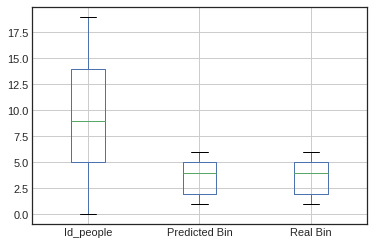

In [34]:
plotar.boxplot()

In [35]:
plotar_mode = plotar.groupby(['Id_people', 'Modality', 'Exposures', 'Real Bin'])[
    'Predicted Bin'].apply(lambda x: sc.stats.mode(x)[0]).reset_index()

plotar_mode['Predicted Bin'] = plotar_mode['Predicted Bin'].astype(int)

plotar_mode.to_csv("../data/processed/original.csv",index=None)

In [36]:
sys.path.append("../src/visualization/")

In [37]:
! Rscript --vanilla ../src/visualization/Figure5.r original.csv original.png

Loading required package: lattice
Loading required package: plyr
null device 
          1 


![Figure 2](../reports/figures/original.png)

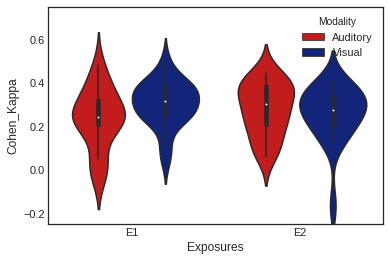

In [55]:
agg_Cohen = []

for ind, person in plotar.groupby(['Id_people','Exposures','Modality']):
    id_pessoa = person['Id_people'].head(1).values.item()
    exposures = person['Exposures'].head(1).values.item()
    modality = person['Modality'].head(1).values.item()
    c_k_s = cohen_kappa_score(y1=person['Real Bin'], y2=person['Predicted Bin'],weights='quadratic')
    agg_Cohen.append([id_pessoa,exposures,modality,c_k_s])

agg_Cohen = pd.DataFrame(agg_Cohen, columns=['id_person','Exposures','Modality','Cohen_Kappa'])

ax = sns.violinplot(x="Exposures", y="Cohen_Kappa", hue="Modality",
                    data=agg_Cohen, palette=['#de0000','#001a8d'])

ax = ax.set(ylim=(-0.25,0.75))

In [57]:
from scipy import stats

In [61]:
stat = agg_Cohen.groupby(['Exposures','Modality'])['Cohen_Kappa'].apply(lambda x: stats.ttest_1samp(x, 0))

In [64]:
pd.DataFrame(stat)

Cohen_Kappa
Exposures Modality                                              
E1        Auditory    (7.653125982239023, 3.216774222969096e-07)
          Visual    (13.146721725121658, 5.4647328934402325e-11)
E2        Auditory  (10.396549714239878, 2.8028742413403247e-09)
          Visual     (8.968138966133653, 2.9510817934260053e-08)

> 5. C) Agreement between decoded and real interval indexed by Cohen's kappa. The left panel shows classification performance when test trials were of the same modality as the training trials while right panels show performance when the test trials were of a different modality than the training trials. Violin plots show the probability density across participants; line markers represent the median. Circles inside the violin plots show data from each participant.

In [39]:
exposicao1 = plotar[plotar['Exposures']=='E1']

exposicao1_aud = exposicao1[exposicao1['Modality']=='Auditory']
exposicao1_vis = exposicao1[exposicao1['Modality']=='Visual']

exposicao2 = plotar[plotar['Exposures']=='E2']

exposicao2_aud = exposicao2[exposicao2['Modality']=='Auditory']
exposicao2_vis = exposicao2[exposicao2['Modality']=='Visual']


print("Classificação nos Dados Visual, exposição 1")

y_test = exposicao1_vis['Predicted Bin'].values
y_pred = exposicao1_vis['Real Bin'].values


print(classification_report(y_test, y_pred))

print("Classificação nos Dados Visual, exposição 2")

y_test = exposicao2_vis['Predicted Bin'].values
y_pred = exposicao2_vis['Real Bin'].values


print(classification_report(y_test, y_pred))

print("Classificação nos Dados Auditivo, exposição 1")
y_test = exposicao1_aud['Predicted Bin'].values
y_pred = exposicao1_aud['Real Bin'].values

print(classification_report(y_test, y_pred))

print("Classificação nos Dados Auditivo, exposição 2")
y_test = exposicao2_aud['Predicted Bin'].values
y_pred = exposicao2_aud['Real Bin'].values
print(classification_report(y_test, y_pred))

Classificação nos Dados Visual, exposição 1
              precision    recall  f1-score   support

           1       0.25      0.31      0.28       298
           2       0.26      0.24      0.25       432
           3       0.15      0.15      0.15       370
           4       0.21      0.20      0.21       444
           5       0.15      0.16      0.16       313
           6       0.30      0.28      0.29       425

    accuracy                           0.22      2282
   macro avg       0.22      0.22      0.22      2282
weighted avg       0.22      0.22      0.22      2282

Classificação nos Dados Visual, exposição 2
              precision    recall  f1-score   support

           1       0.25      0.29      0.27       307
           2       0.22      0.24      0.23       372
           3       0.15      0.16      0.15       328
           4       0.23      0.20      0.21       495
           5       0.16      0.17      0.16       333
           6       0.28      0.25      0.26 

# Balancelamento das classes


## Distribuição das classes

In [40]:
def plot_balanceamento(df, ax, name='Real Bin'):
    return df[name].plot.hist(bins=6, ax=ax)

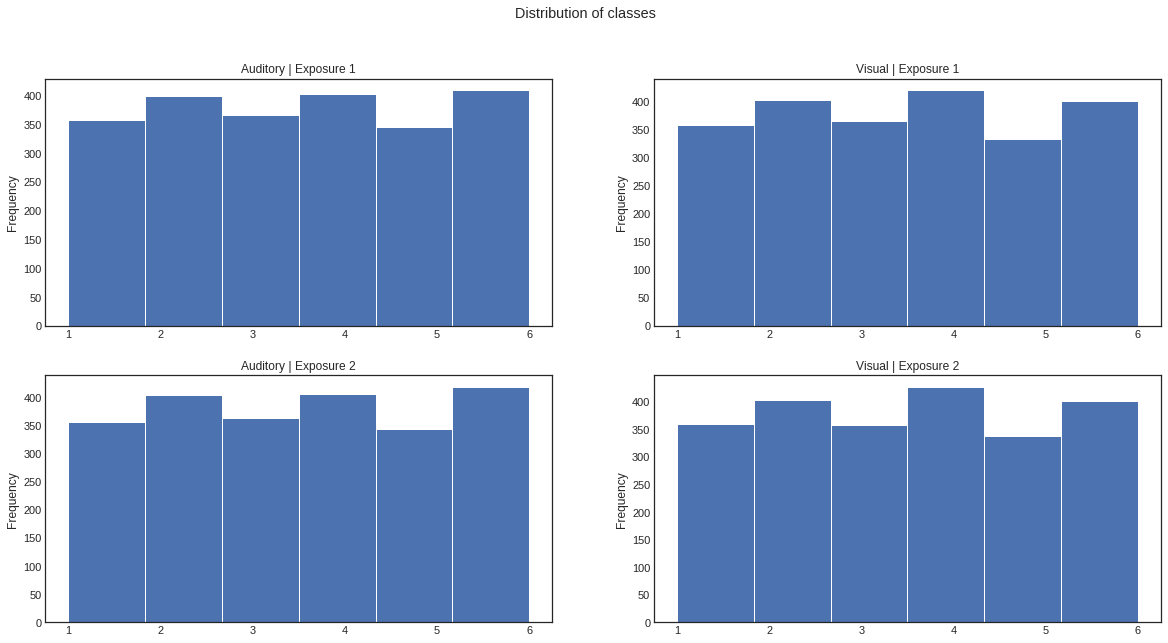

In [41]:
fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(20,10))

plot_balanceamento(exposicao1_aud, ax=ax[0][0])
ax[0][0].set_title("Auditory | Exposure 1")
plot_balanceamento(exposicao2_aud, ax=ax[1][0])
ax[1][0].set_title("Auditory | Exposure 2")

plot_balanceamento(exposicao1_vis, ax=ax[0][1])
ax[0][1].set_title("Visual | Exposure 1")

plot_balanceamento(exposicao2_vis, ax=ax[1][1])
ax[1][1].set_title("Visual | Exposure 2")

fig.suptitle("Distribution of classes")
plt.show()

# Checagem do rótulos às médias

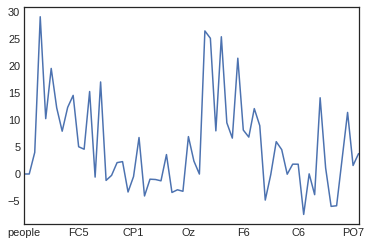

In [42]:
df_aud_1_aver.loc[0][:-3].plot()

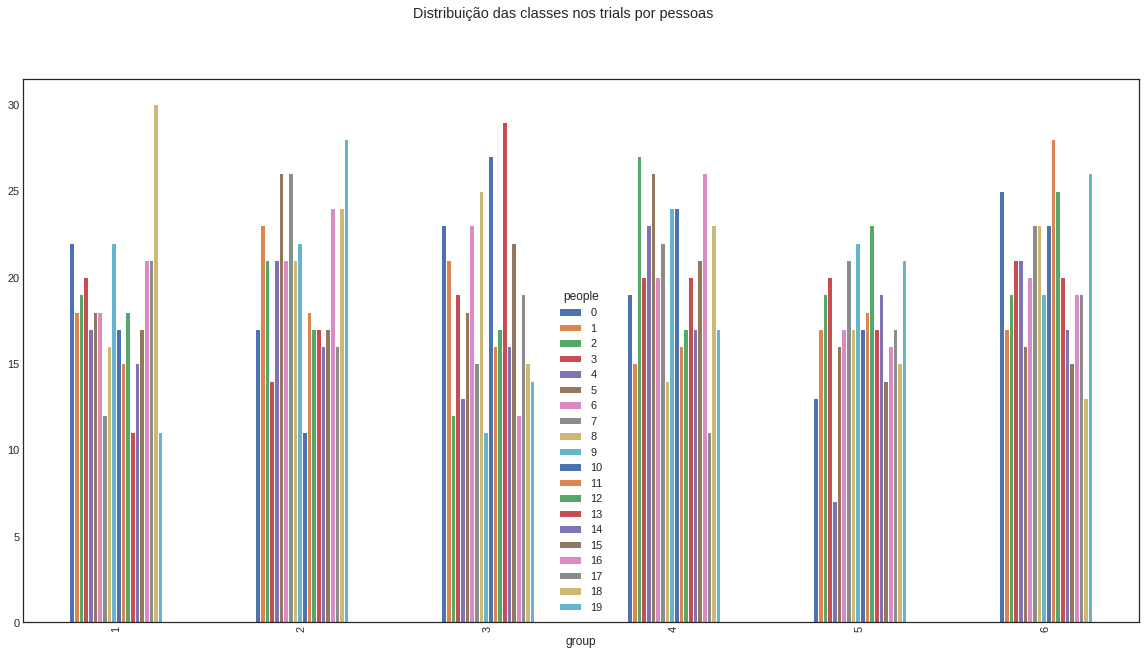

In [43]:
contagem_pessoas_classe = df_aud_1_aver.groupby(['people','group']).size().unstack()

fig, ax = plt.subplots(figsize=(20,10))

ax = contagem_pessoas_classe.T.plot.bar(ax=ax)

fig = fig.suptitle("Distribuição das classes nos trials por pessoas")


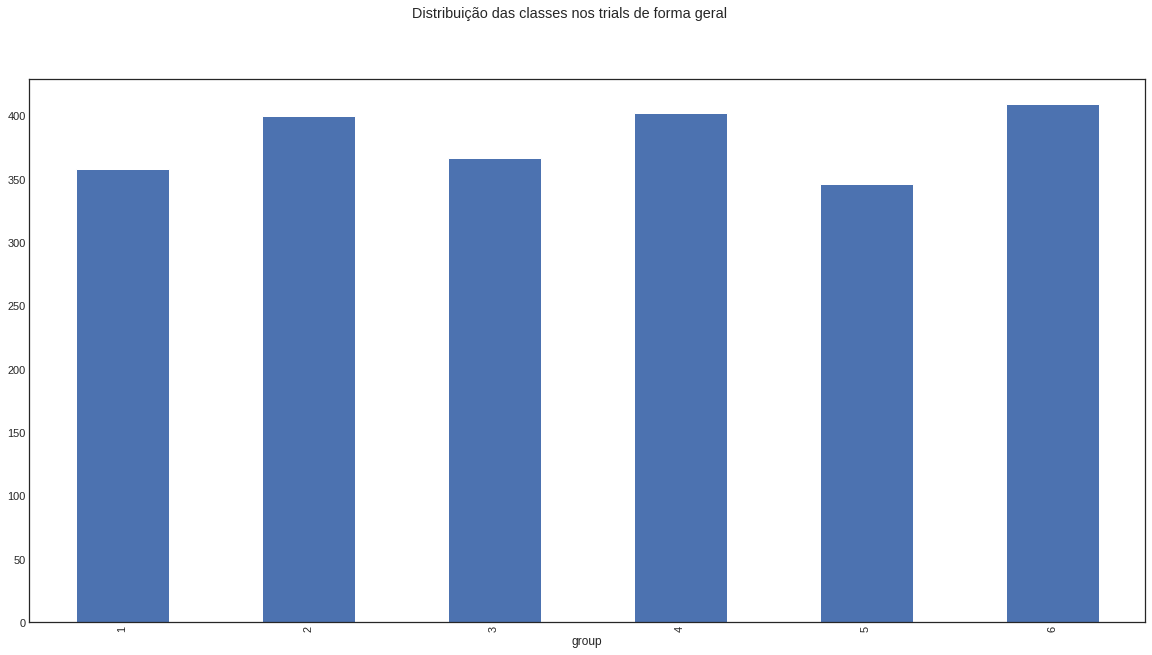

In [44]:
contagem_classe = df_aud_1_aver.groupby(['group']).size()
fig, ax = plt.subplots(figsize=(20,10))

ax = contagem_classe.T.plot.bar(ax=ax)

fig = fig.suptitle("Distribuição das classes nos trials de forma geral")


## Inspeção por permutação

In [53]:
def makeCatPlot_Inspeção(dataFrame, categoria, exposicao, plot=True):
    dataFrame_result = []
    loo = LeaveOneOut()

    pbar = tqdm(total=loo.get_n_splits(dataFrame))

    resu_importance_total = []
    for ind, pearson in dataFrame.groupby('people'):

        X = pearson.drop(['trial', 'group', 'people'], 1)
        y = pearson['group']

        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=42)

        # Normalize
        train_mean = np.average(X_train, axis=0)

        X_train_without_mean = np.subtract(X_train, train_mean)
        X_test_without_mean = np.subtract(X_test, train_mean)

        clf = GaussianNB()
        pca_ = PCA(random_state=42, svd_solver='full', n_components=0.99)

        pca = pca_.fit(X_train_without_mean)

        X_train_pca = pca.transform(X_train_without_mean)

        X_test_pca = pca.transform(X_test_without_mean)

        clf = GaussianNB()

        cv_score = cross_val_score(clf, X_train_pca, y_train, cv=10).mean()

        clf.fit(X_train_pca, y_train)

        y_pred = clf.predict(X_test_pca)

        dataFrame_result.append(
            [y_pred, y_test, cv_score, categoria, exposicao])

        if(plot):

            result = permutation_importance(clf, X_train_pca, y_train, n_repeats=10,
                                            random_state=42, n_jobs=2)
            sorted_idx = result.importances_mean.argsort()

            fig, ax = plt.subplots(figsize=(10, 25))
            ax.boxplot(result.importances[sorted_idx].T,
                       vert=False, labels=X_train.columns[sorted_idx])
            ax.set_title("Permutation Importances\n| Pearson" + str(ind) +
                         " \n| Modality "+categoria+' | Exposure: ' + exposicao)
            fig.tight_layout()
            plt.show()

    return dataFrame_result

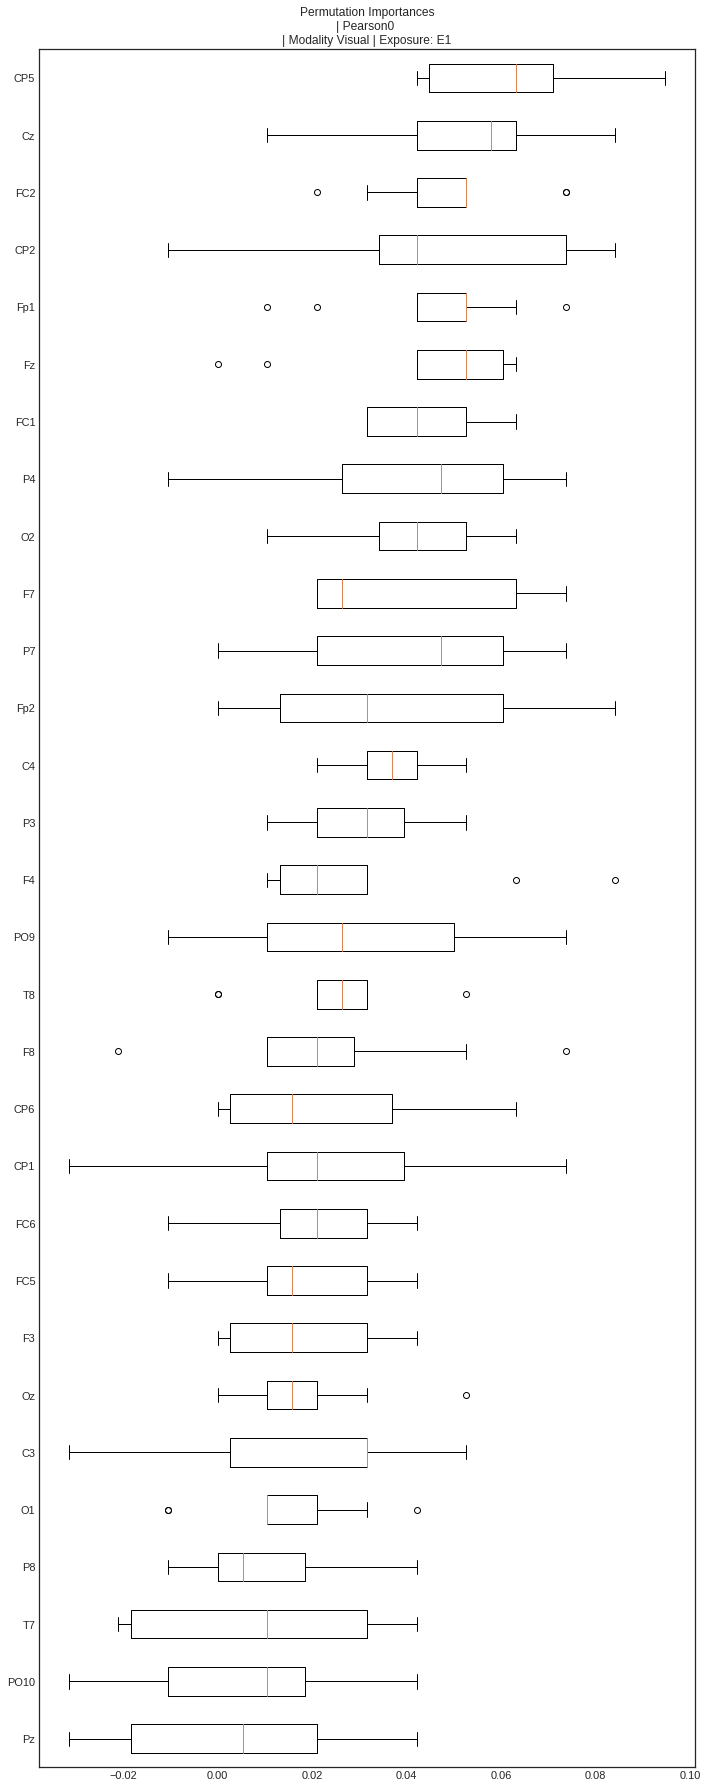

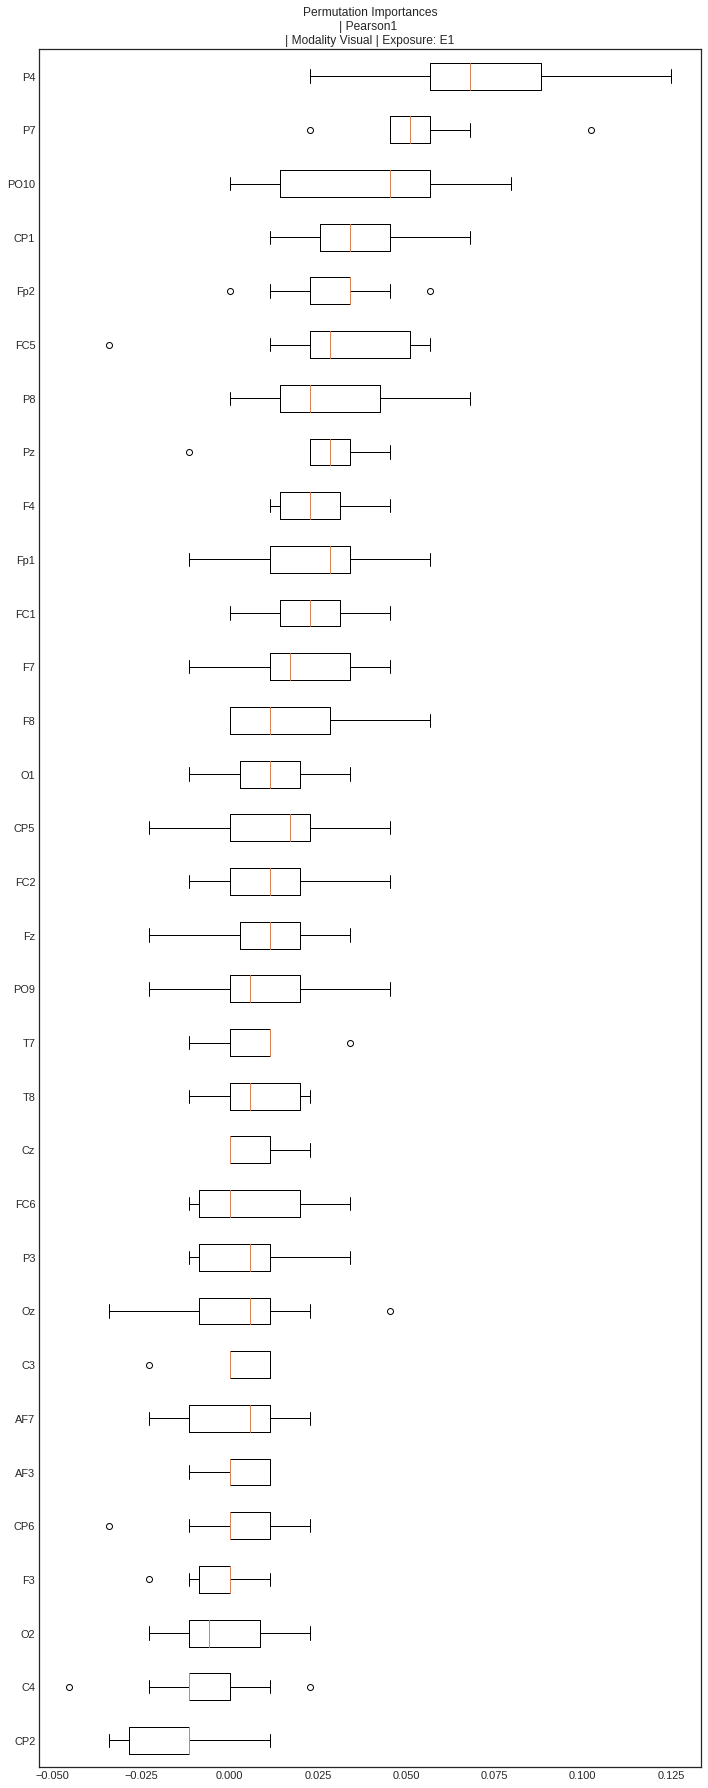

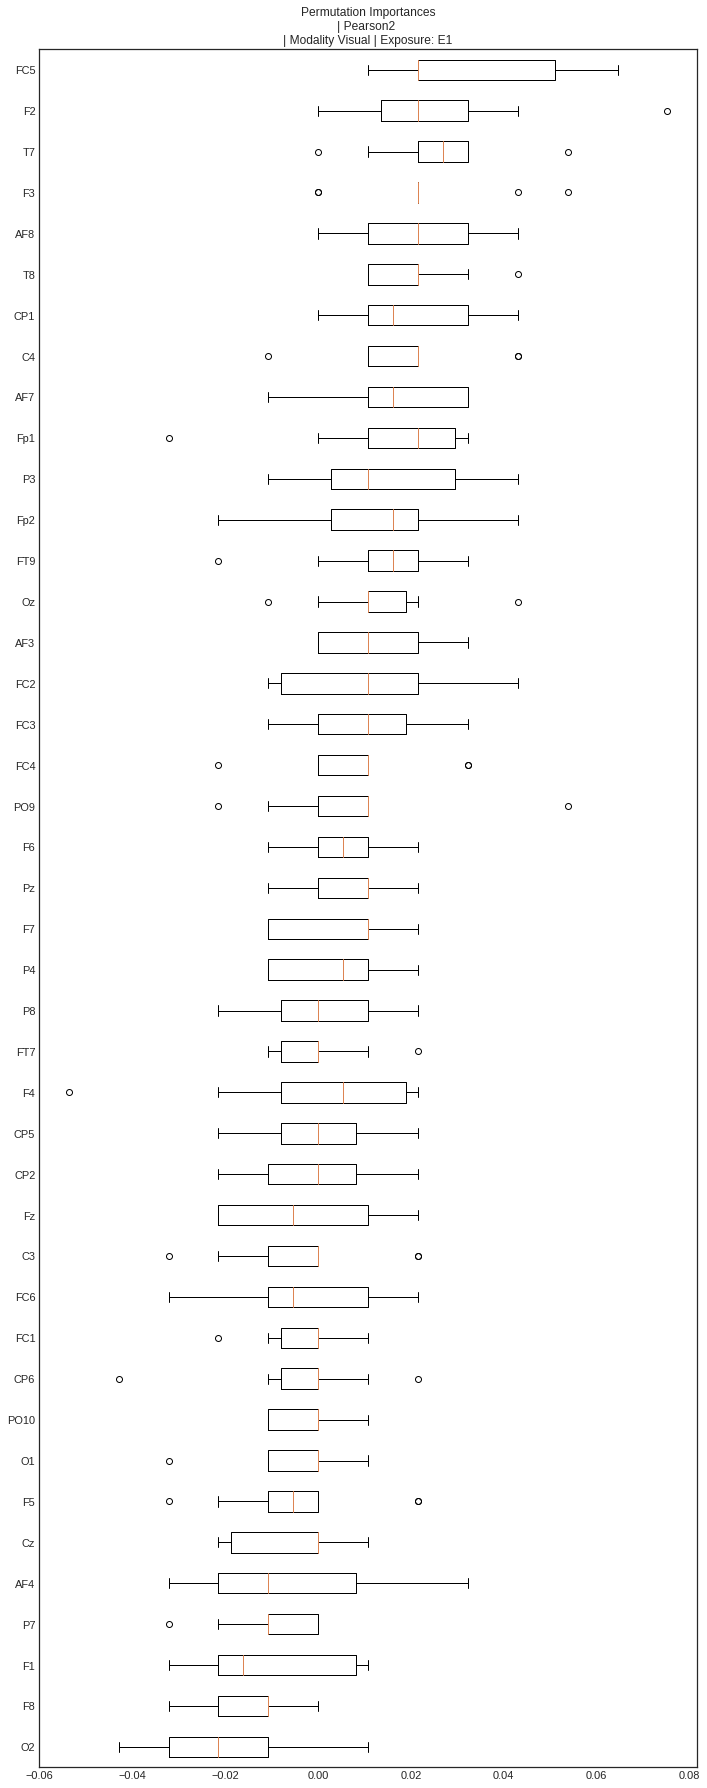

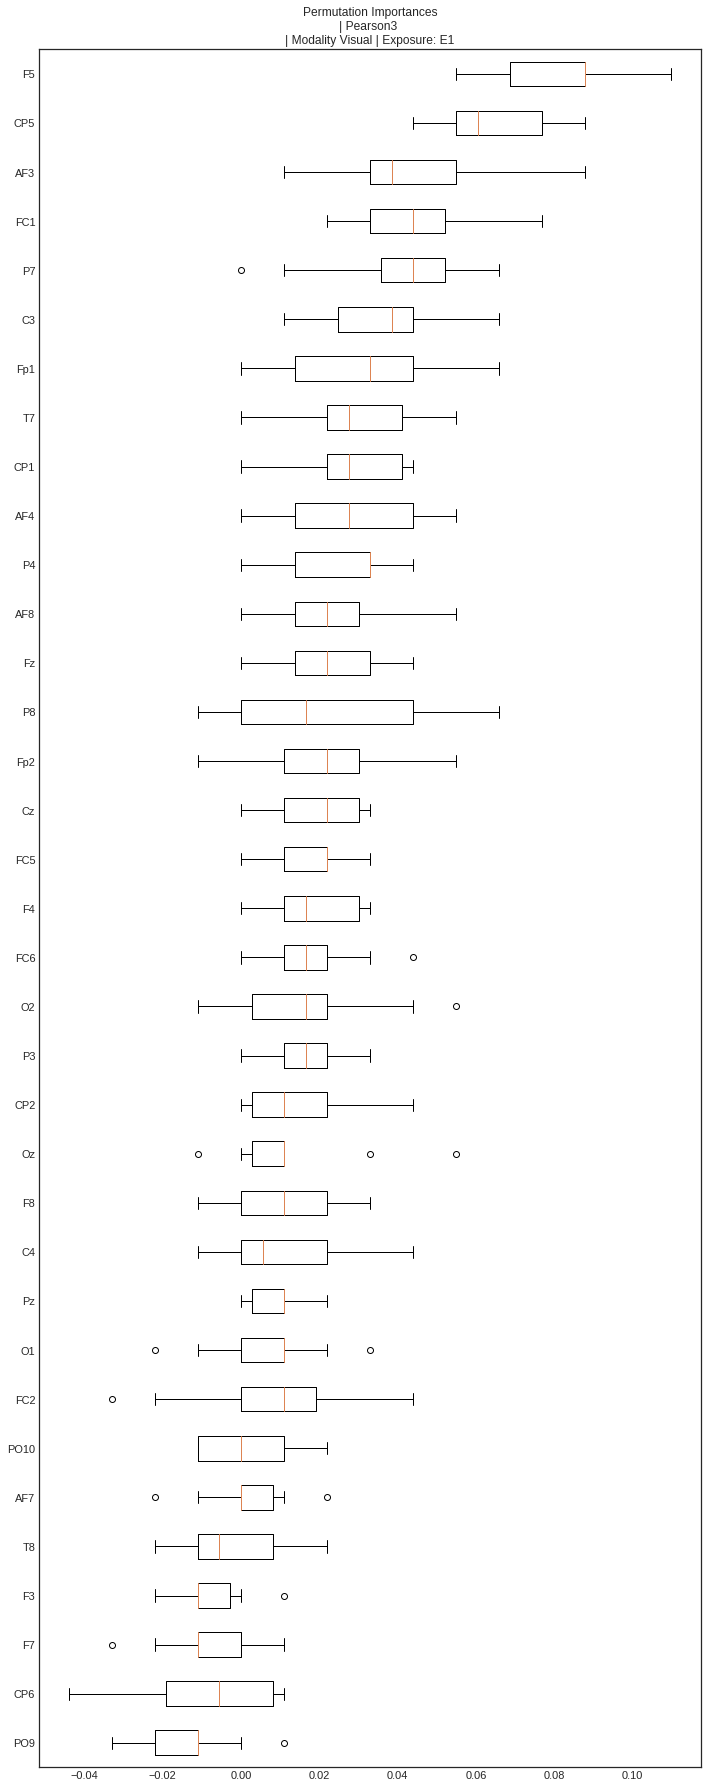

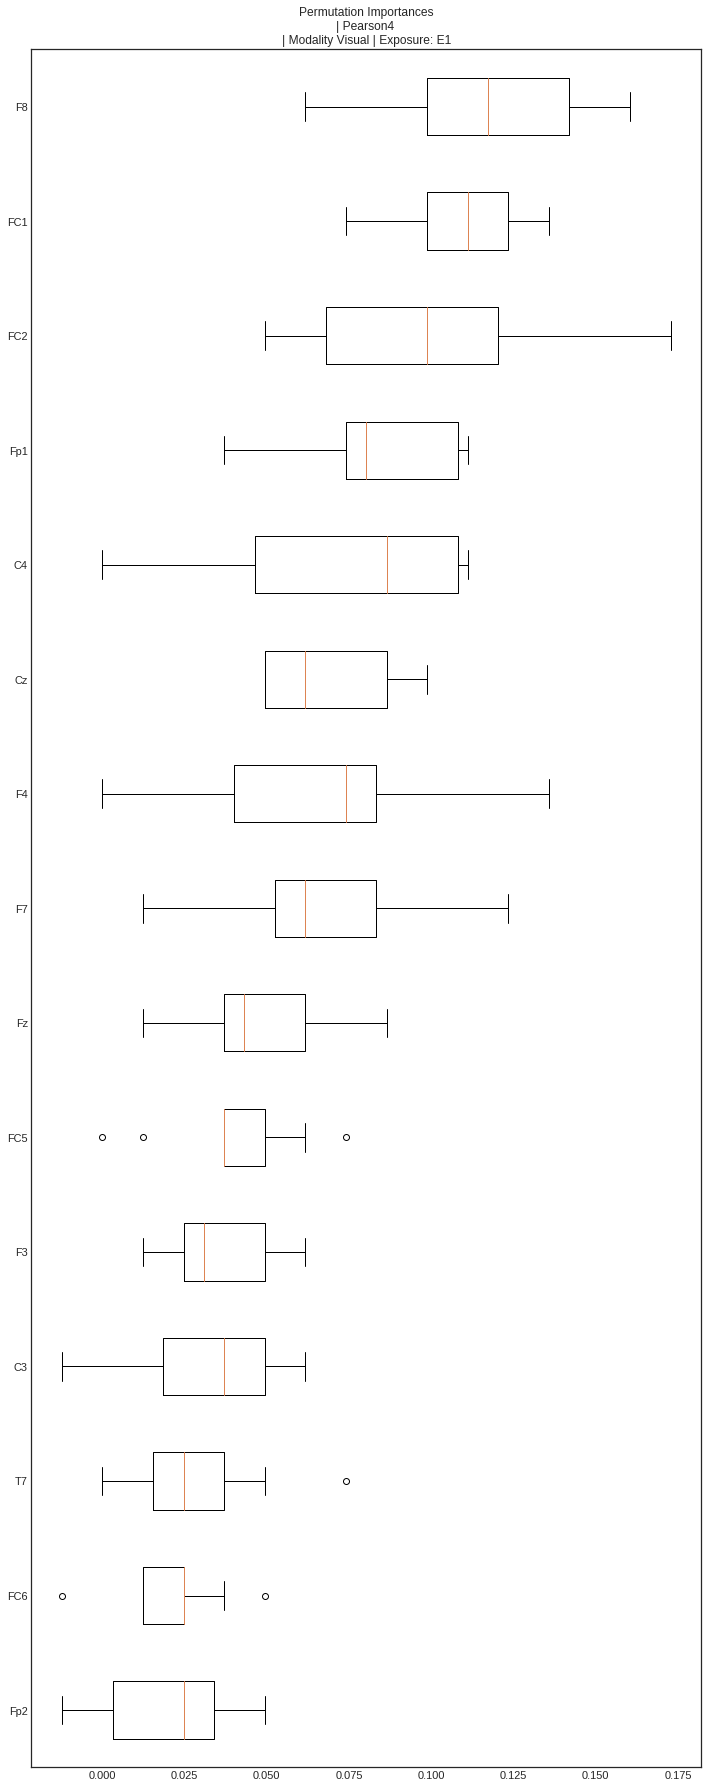

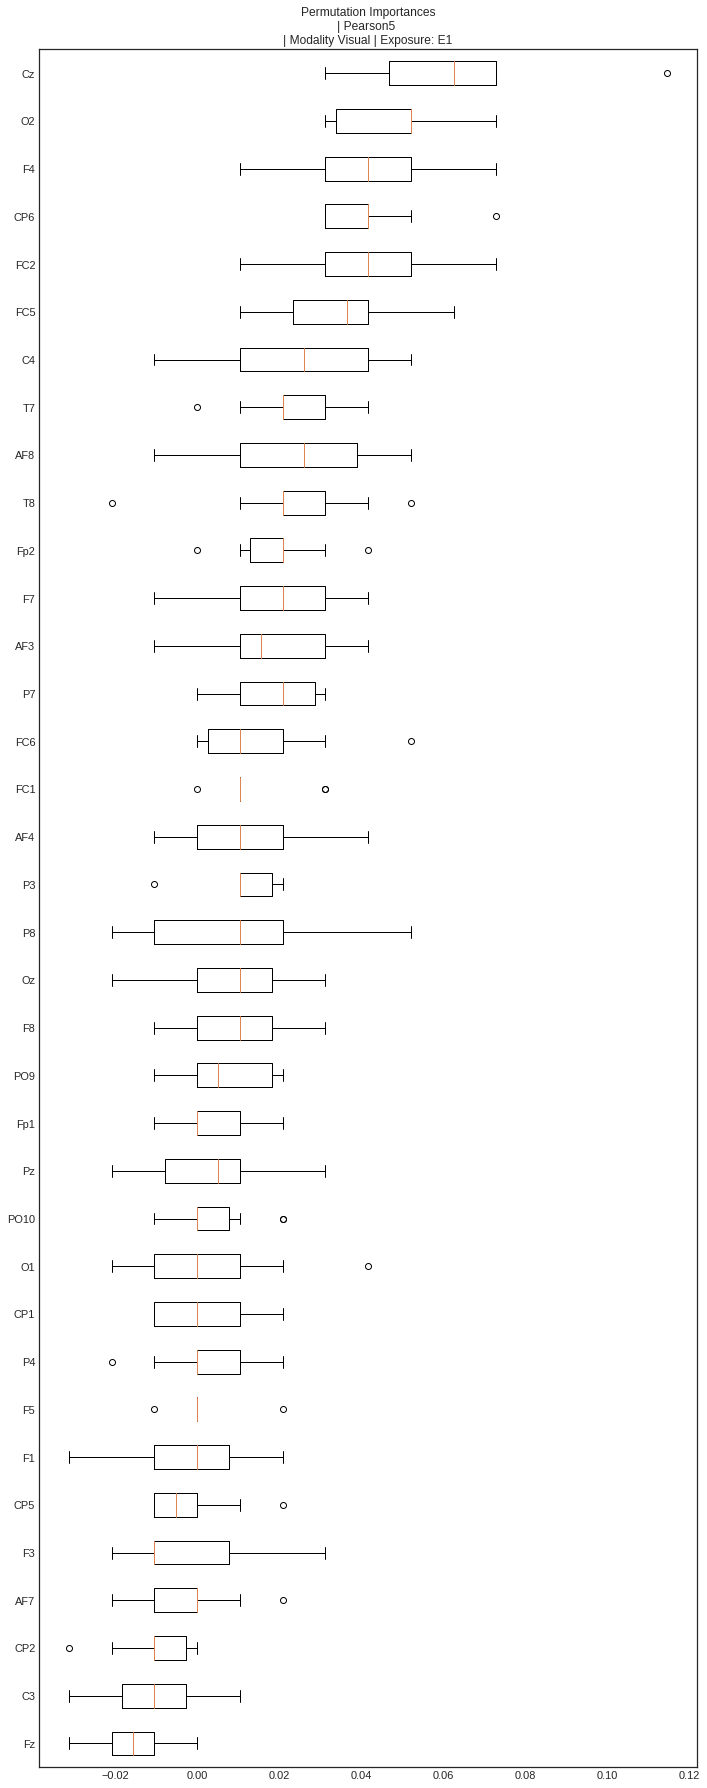

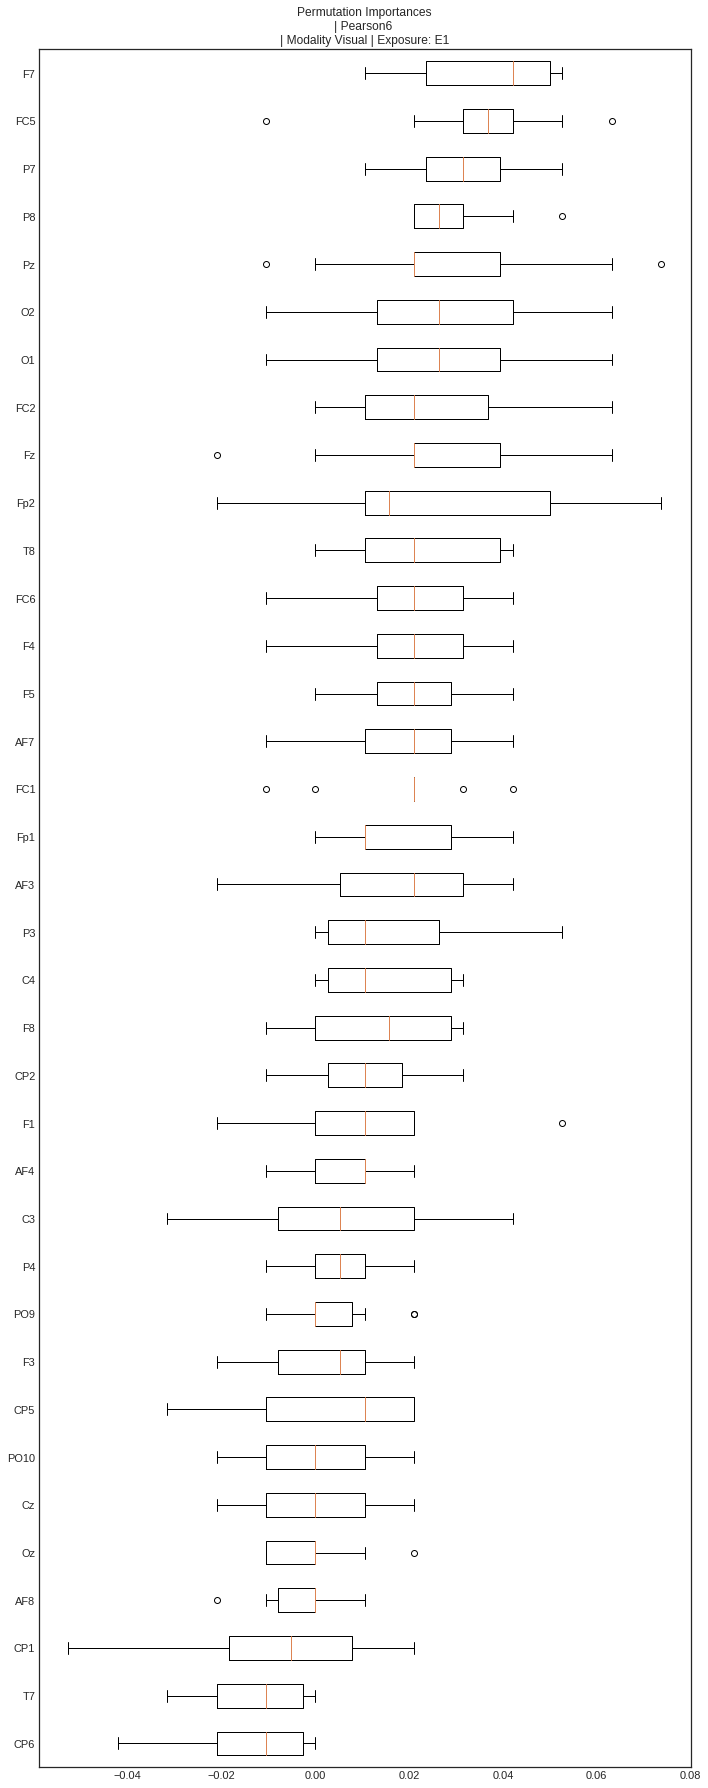

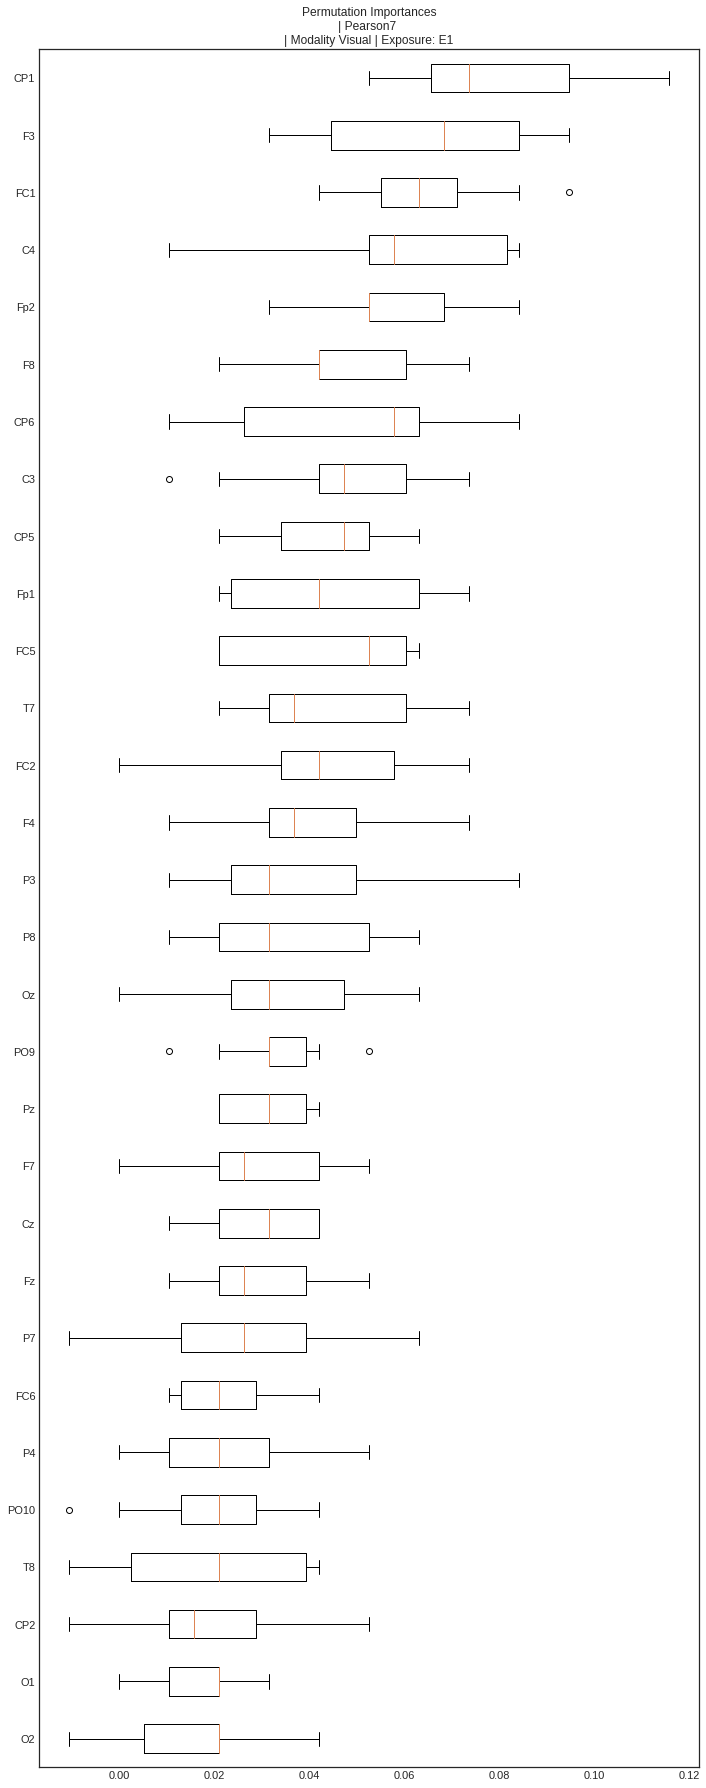

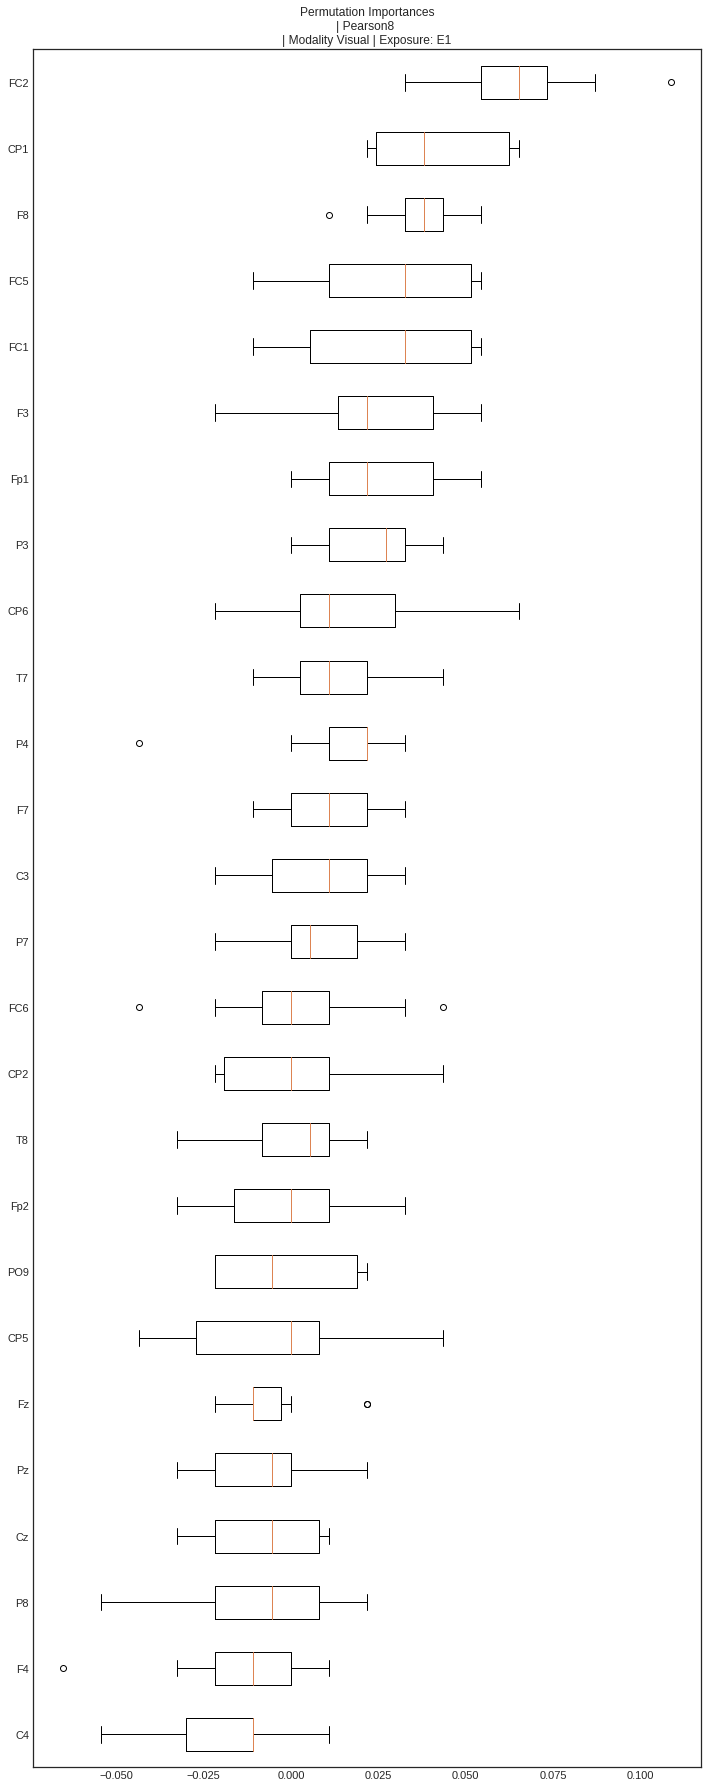

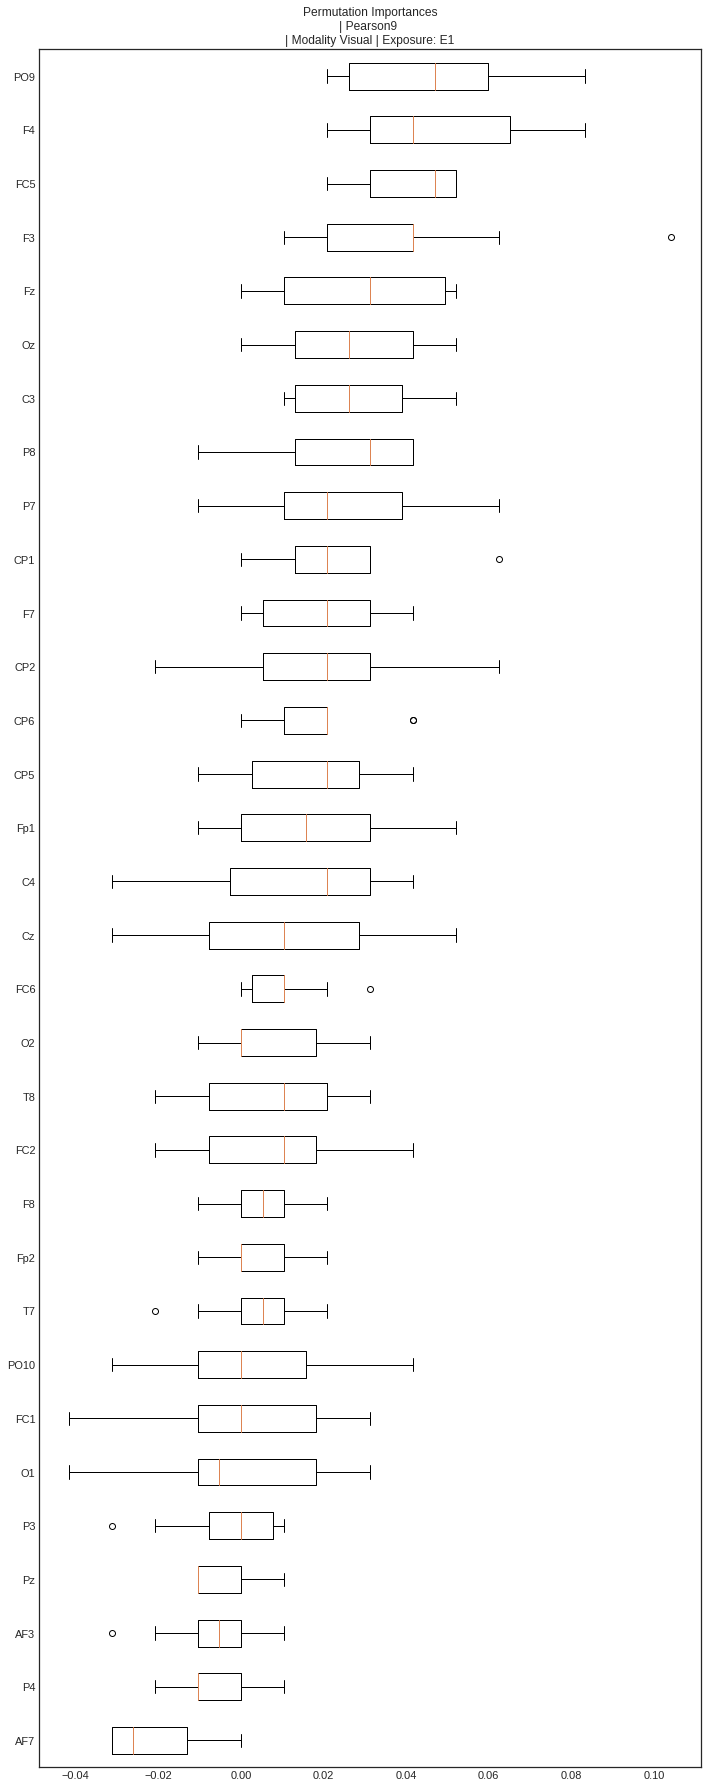

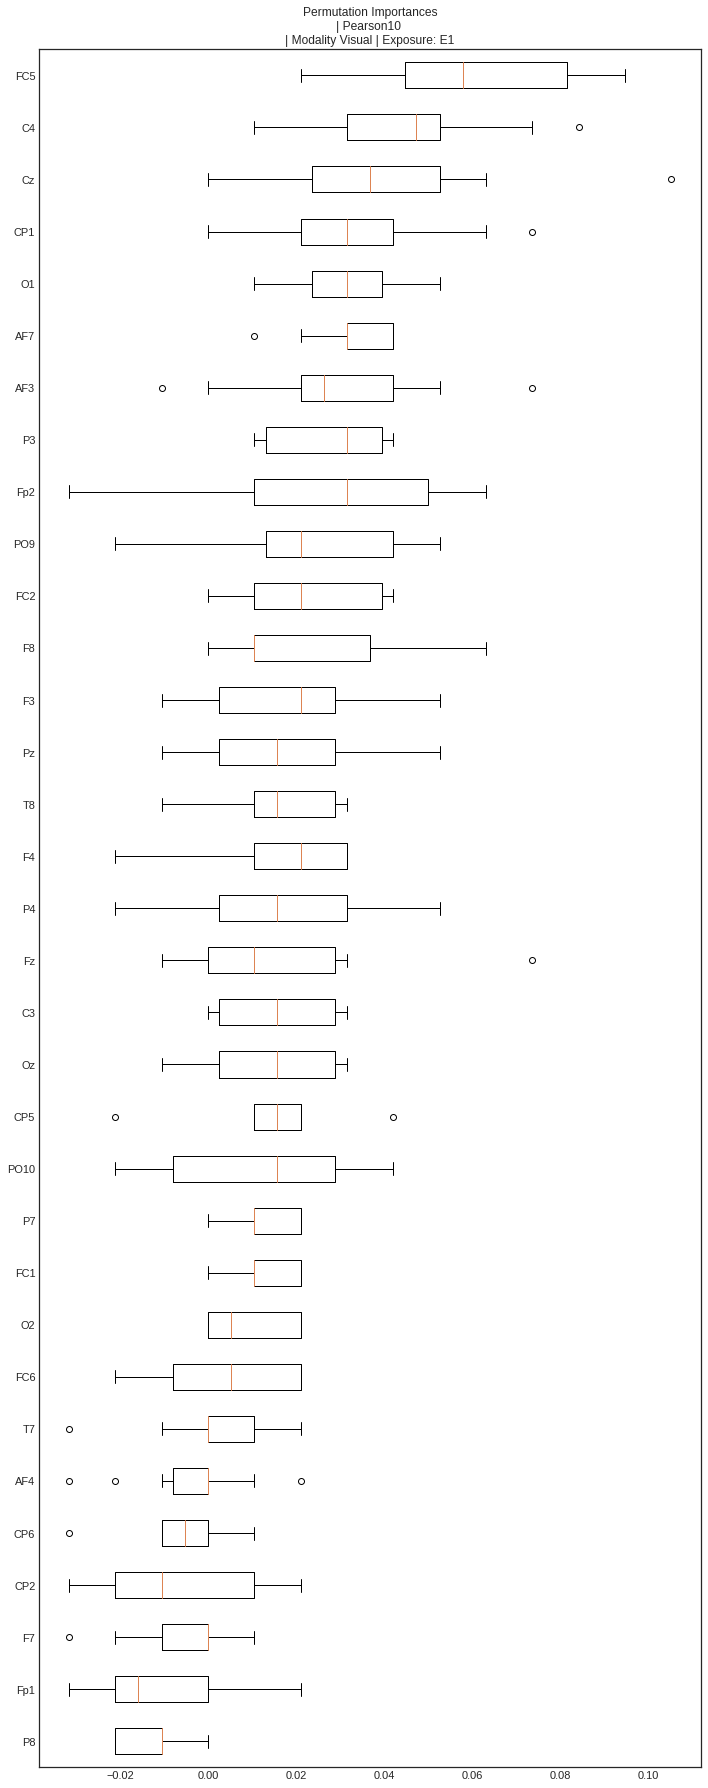

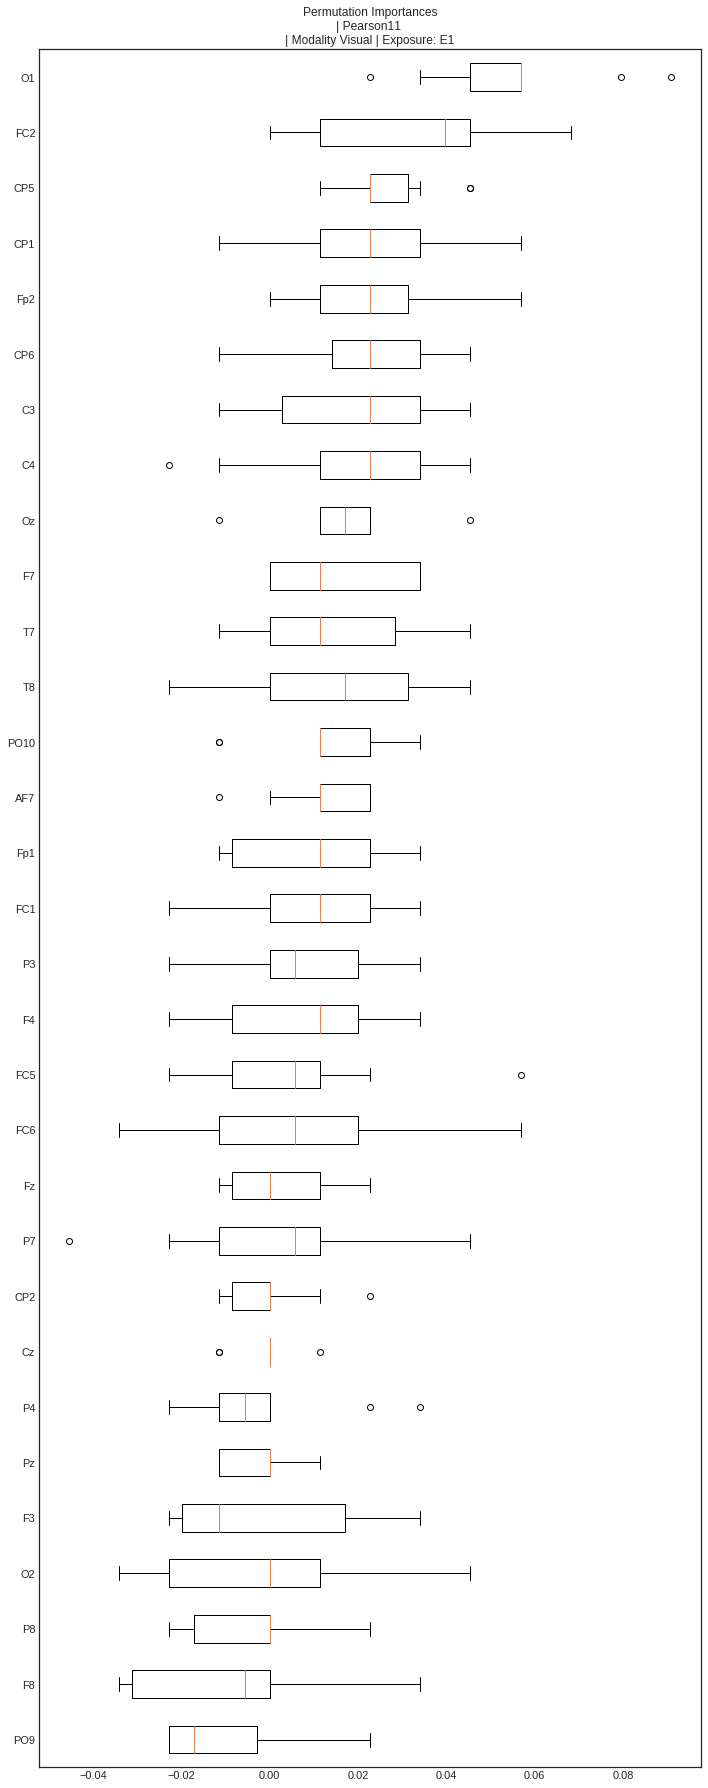

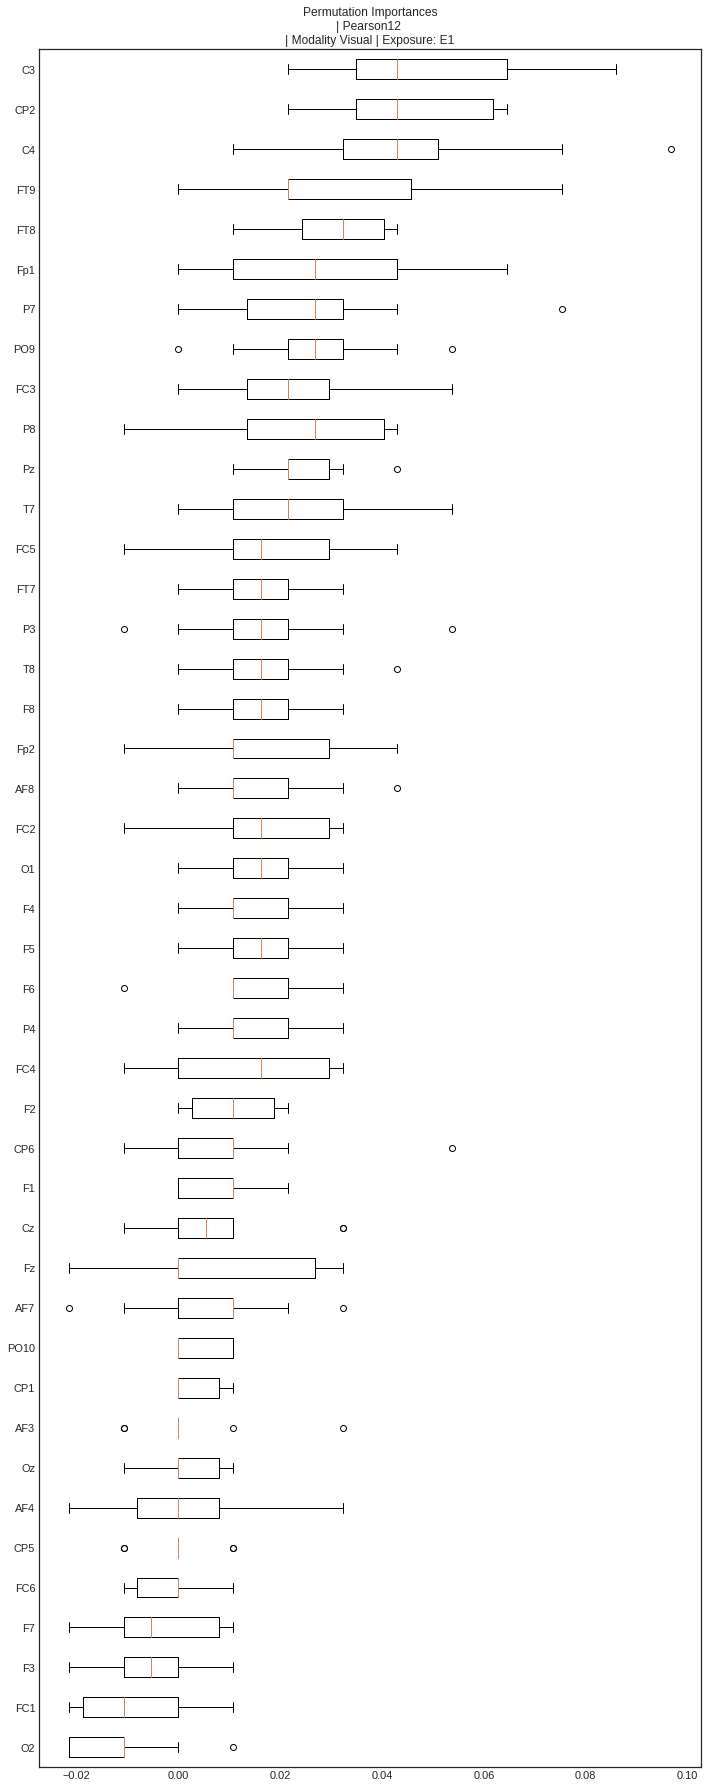

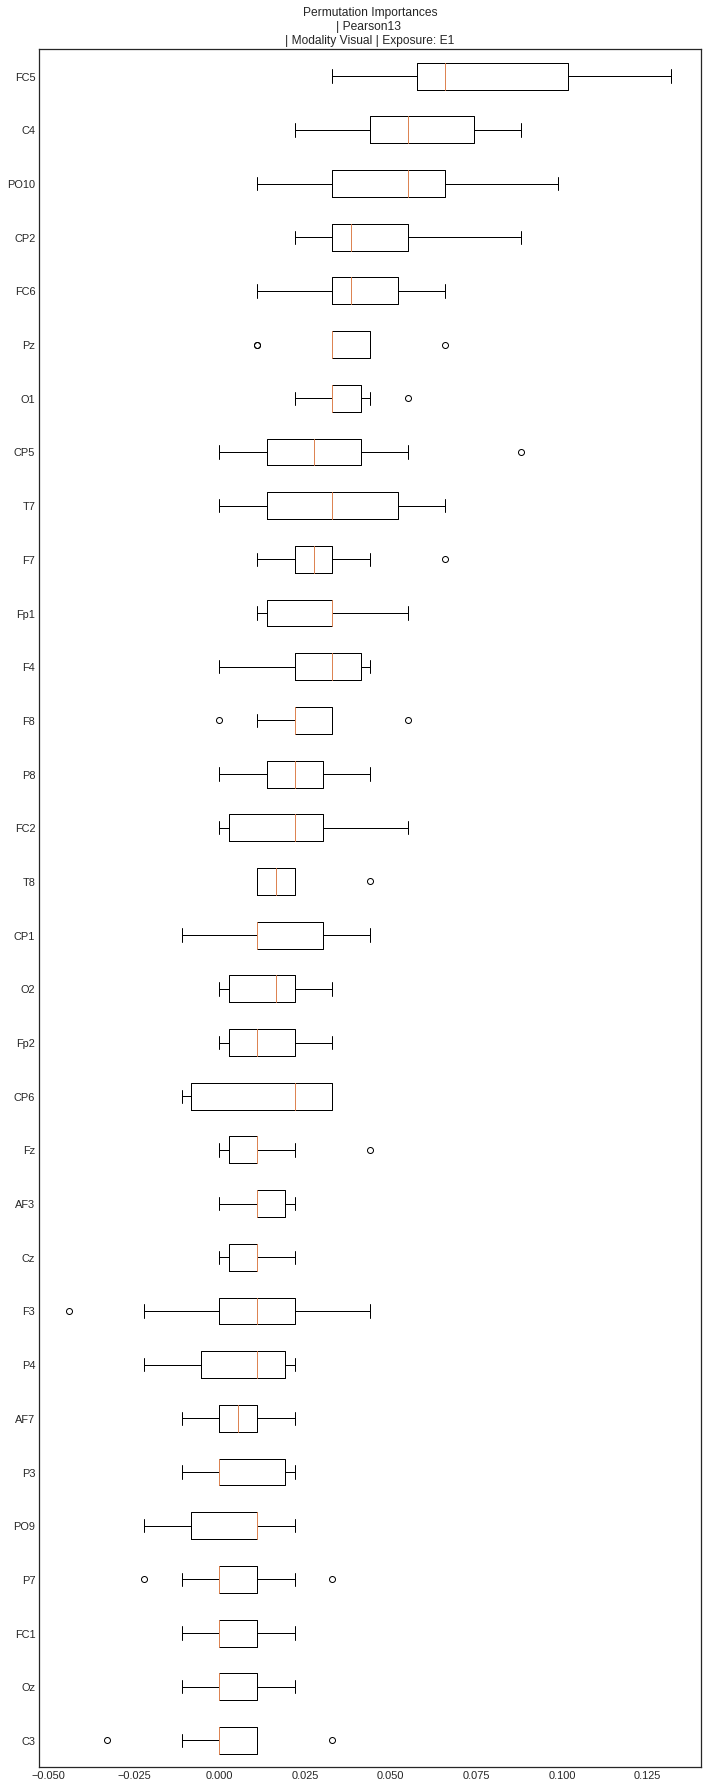

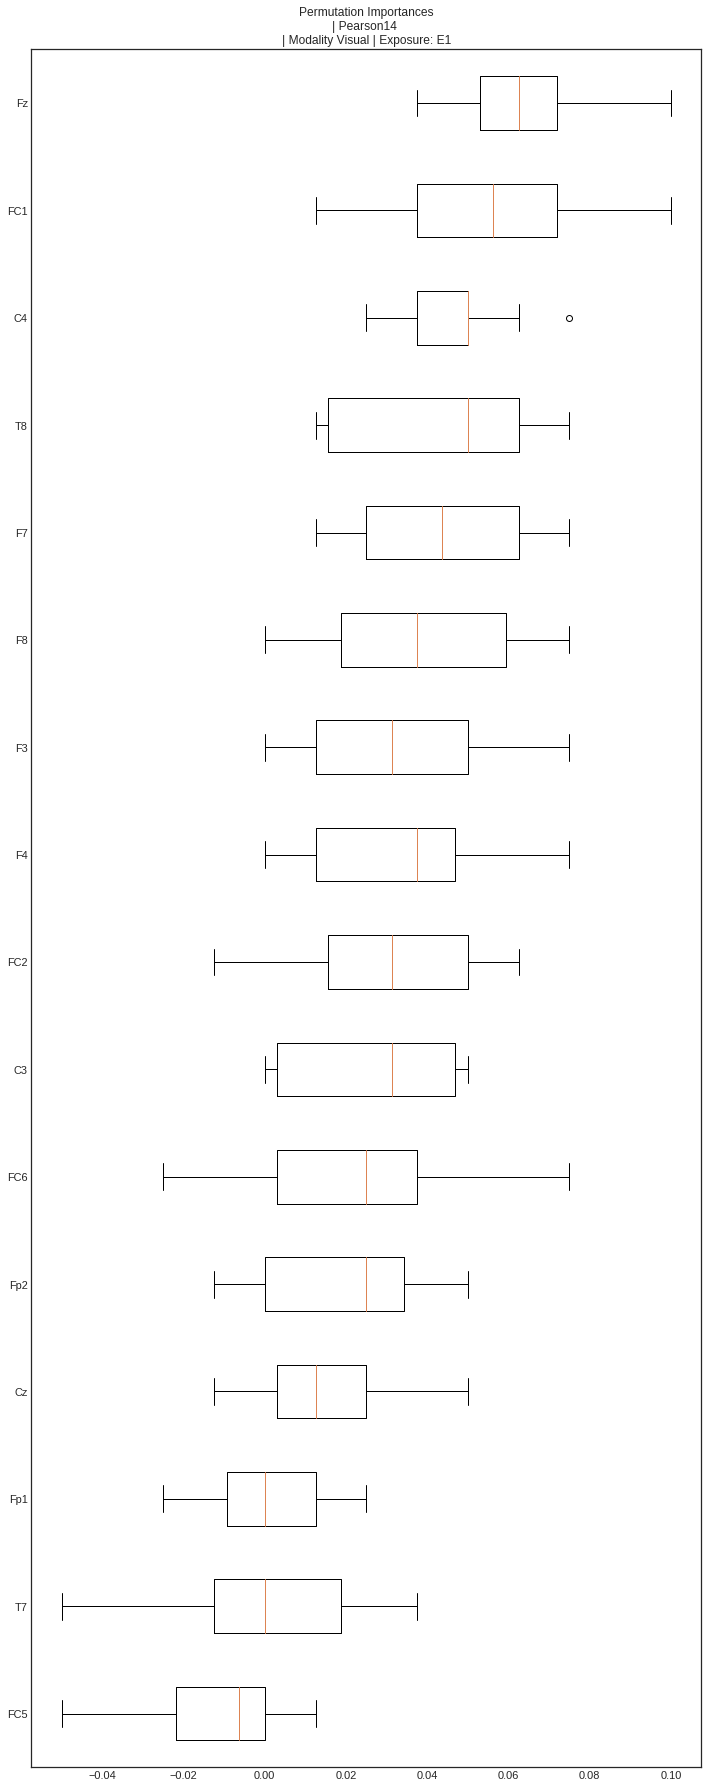

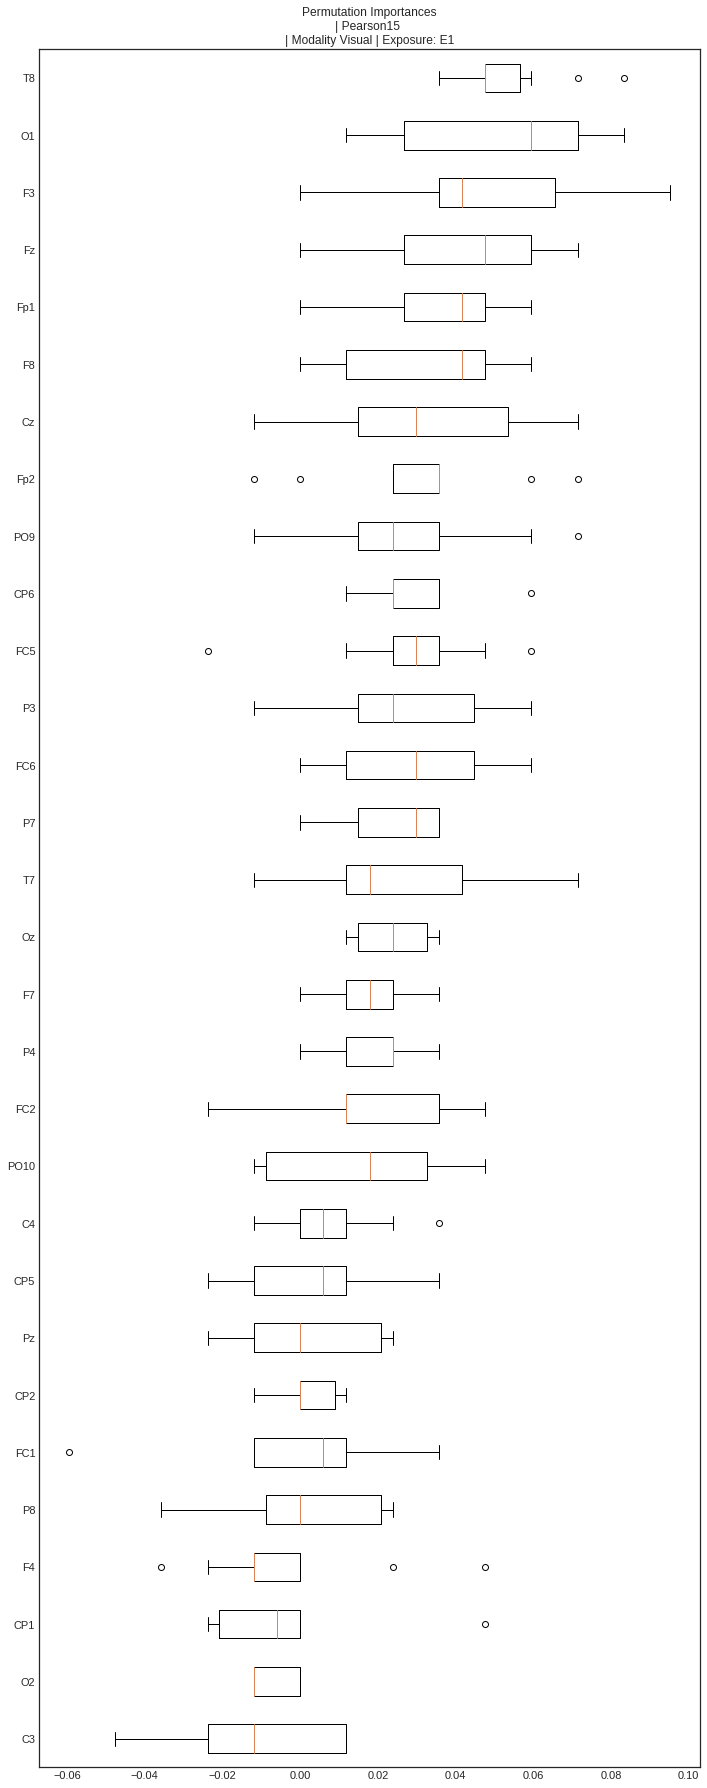

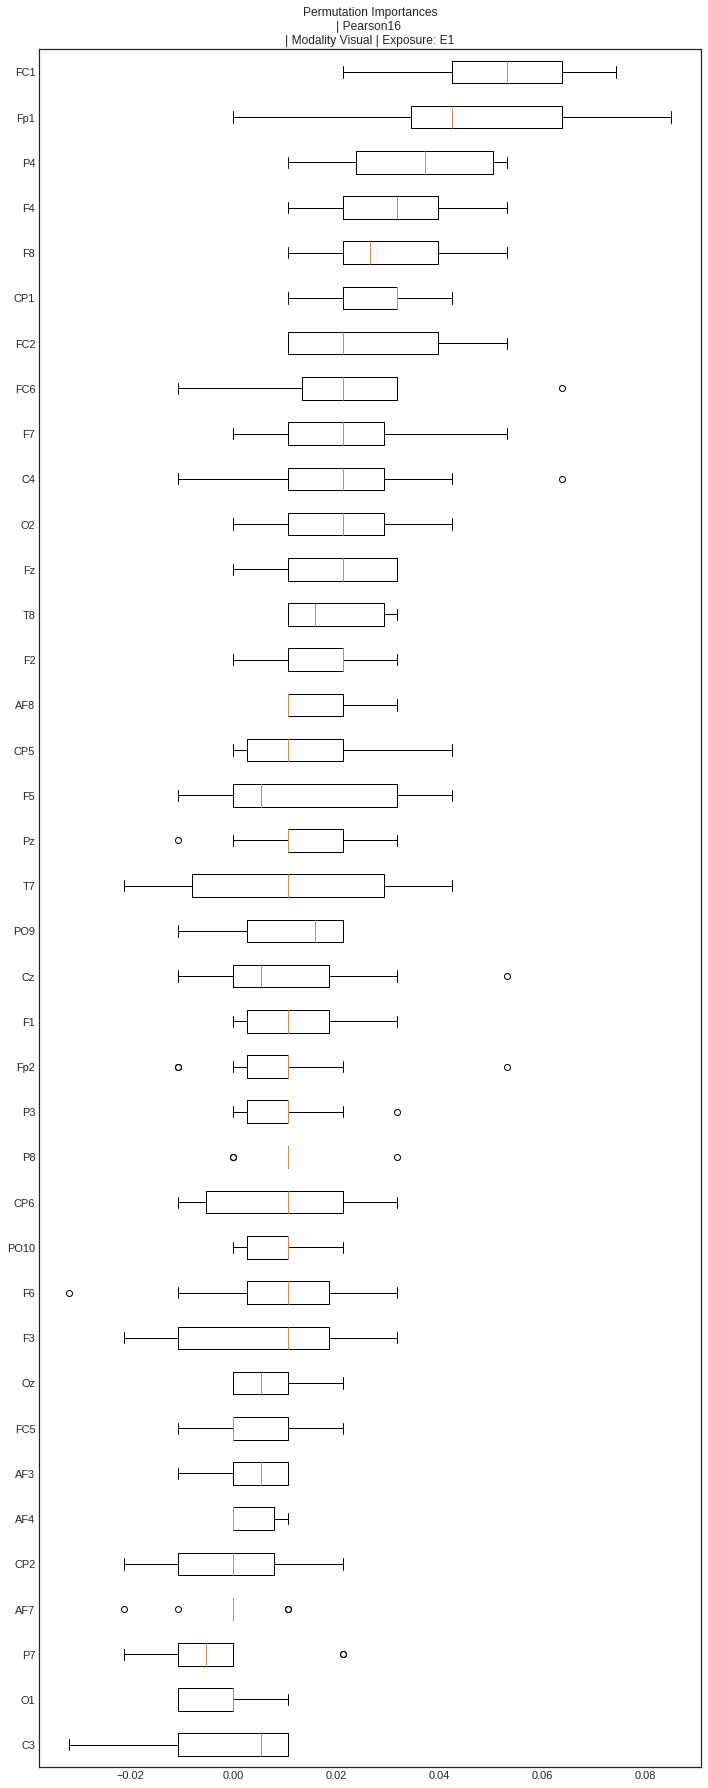

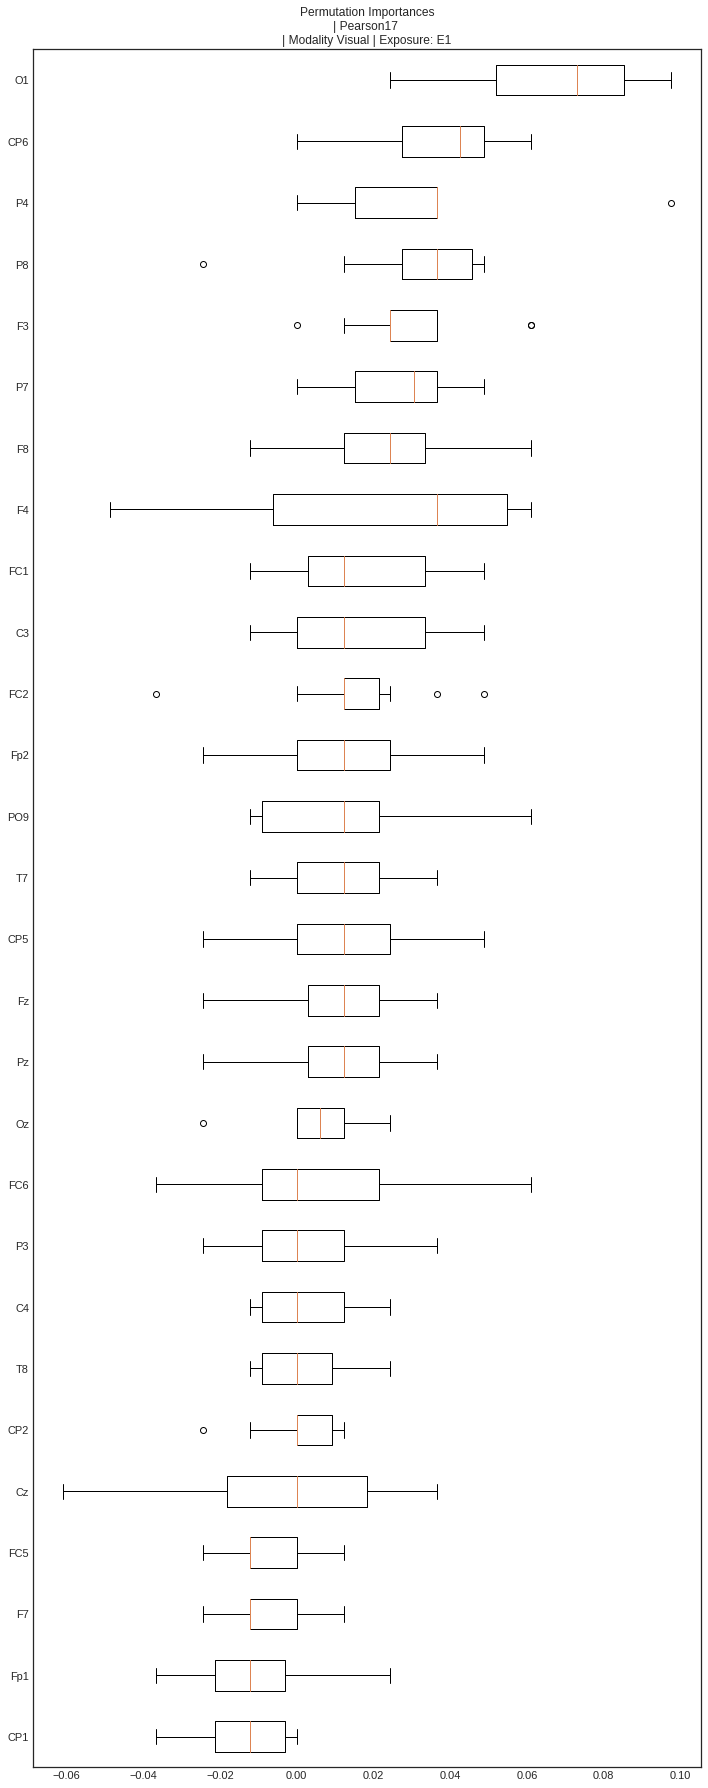

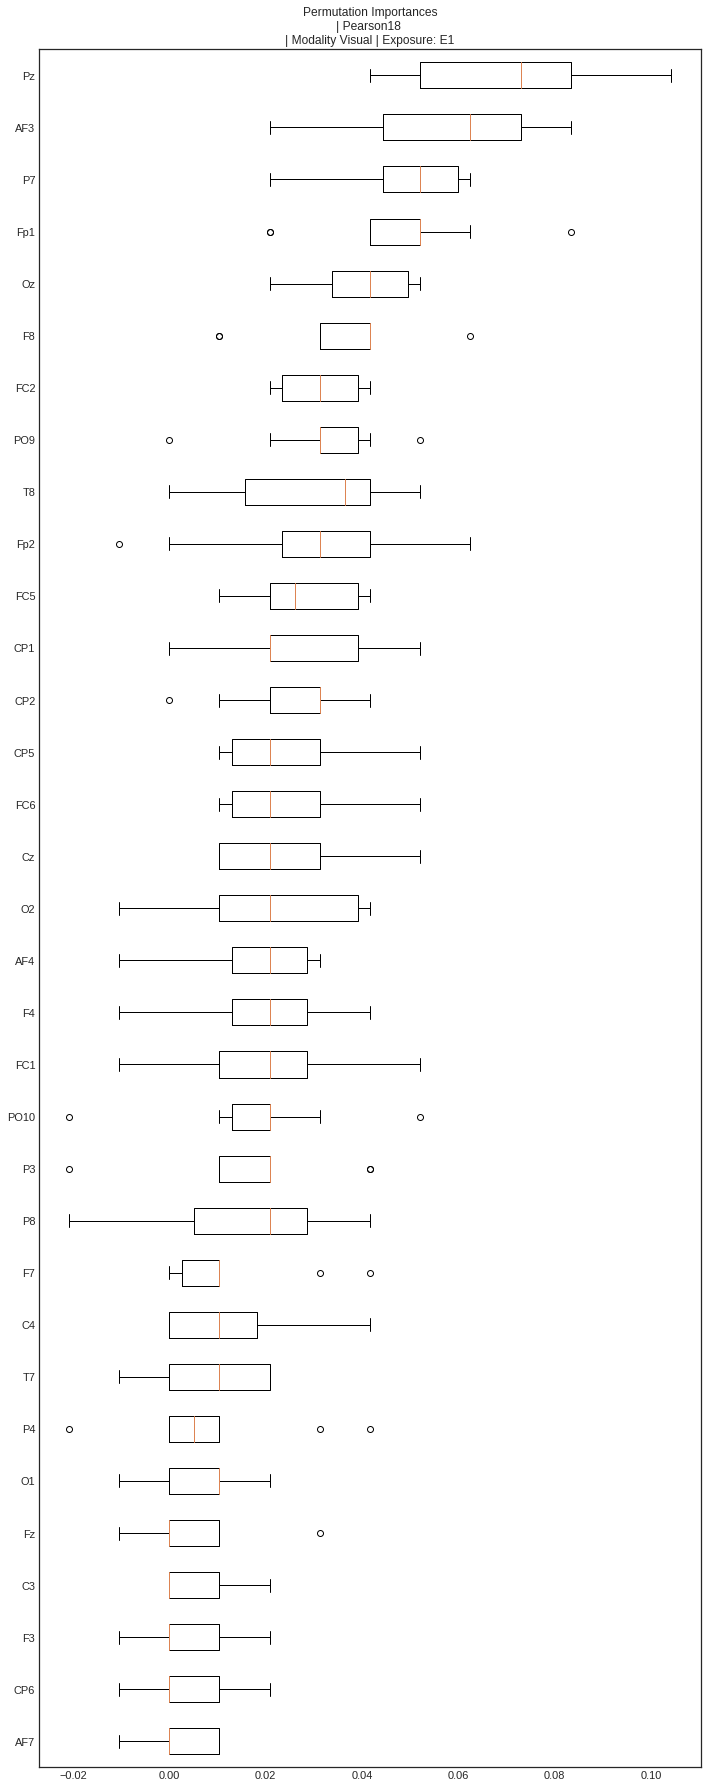

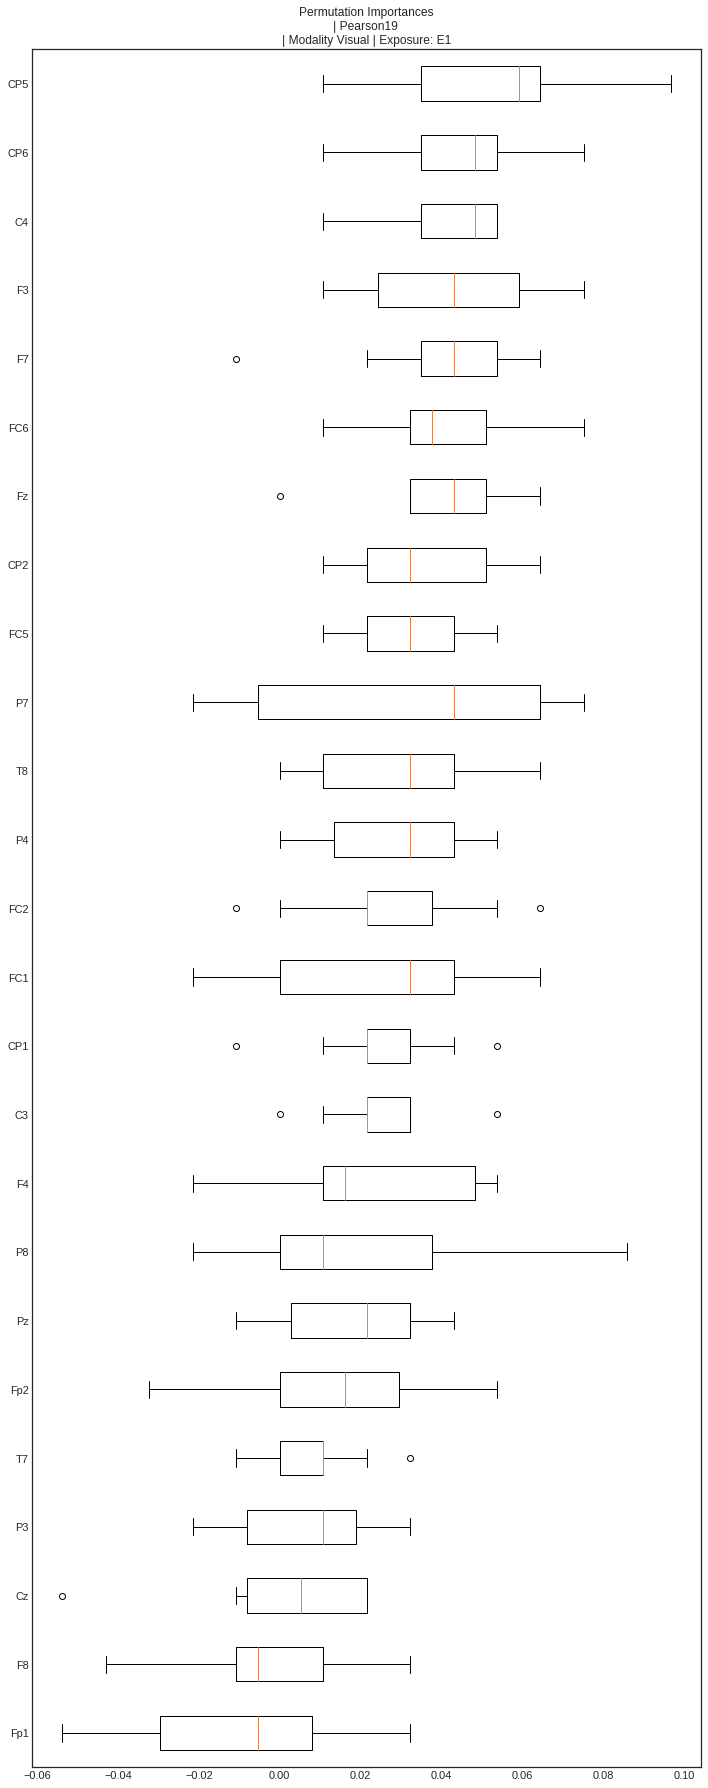

In [54]:
resu_vis_1_w_i = makeCatPlot_Inspeção(df_vis_1_aver,'Visual','E1')


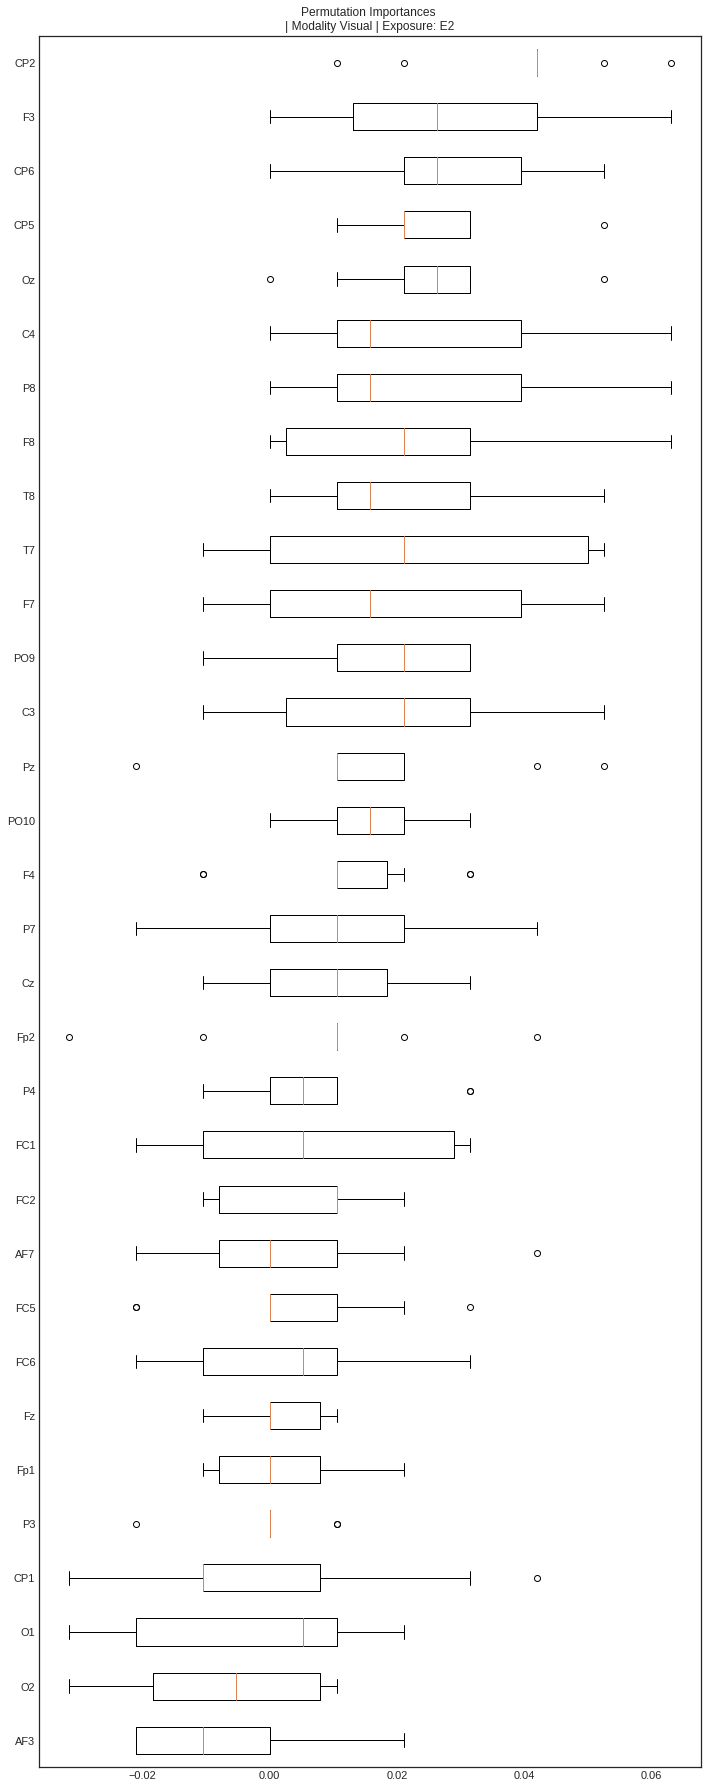

KeyboardInterrupt: 

In [47]:
resu_vis_2_w_i = makeCatPlot_Inspeção(df_vis_2_aver,'Visual','E2')


In [ ]:
resu_aud_1_w_i = makeCatPlot_Inspeção(df_aud_1_aver,'Auditory','E1')


In [ ]:
resu_aud_2_w_i = makeCatPlot_Inspeção(df_aud_2_aver,'Auditory','E2')

In [ ]:
doctest.testmod(verbose=True)

In [ ]:
def get_last_125ms_autoenconder(data, indices):
    return get_last_125ms(data, indices, average=False)

In [ ]:
def to_DataFrame_autoenconder(data, classe):
    '''
    TO-DO
    
    '''
    x_array = xr.DataArray(data)
    x_array = x_array.rename({'dim_0': 'people','dim_1': 'channel','dim_2':'time','dim_3':'trial'})
    x_array = x_array.transpose('people', 'trial', 'channel','time')
    x_array.to_dataframe('channel').unstack()

    df = x_array.to_dataframe('time').unstack()

    df_classe =  pd.DataFrame(classe.stack()).reset_index()
    df_classe.columns = ['people','trial','group']
    df_v = df_classe.merge(df,on=['people','trial'], validate='one_to_many',how='outer')
    df_v['channel'] = df.reset_index()['channel']

    df_v['channel'].replace(dict(zip(list(range(64)),CHANNEL_NAMES)), inplace=True)

    time_legend = ['time '+str(i) for i in range(32)]

    df_v.columns = ['people',  'trial', 'group']+time_legend+['channel']

    df_v = df_v[['people',  'trial', 'group','channel']+time_legend]

    df_v = df_v[~((df_v['channel'] =='HEOG') | (df_v['channel'] =='VEOG'))]


    return df_v

In [ ]:
aud_1_autoenconder = list(map(get_last_125ms_autoenconder, aud_1, indice_s2_aud))
aud_2_autoenconder = list(map(get_last_125ms_autoenconder, aud_2, indice_s2_aud))


vis_1_autoenconder = list(map(get_last_125ms_autoenconder, vis_1, indice_s2_vis))
vis_2_autoenconder = list(map(get_last_125ms_autoenconder, vis_2, indice_s2_vis))

In [ ]:
df_aud_1_autoenconder = to_DataFrame_autoenconder(aud_1_autoenconder,classes_aud)
df_aud_2_autoenconder = to_DataFrame_autoenconder(aud_2_autoenconder,classes_aud)

df_vis_1_autoenconder = to_DataFrame_autoenconder(vis_1_autoenconder,classes_vis)
df_vis_2_autoenconder = to_DataFrame_autoenconder(vis_2_autoenconder,classes_vis)

In [ ]:
df_aud_1_autoenconder.to_csv("../data/processed/auditory_exposure_1_autoenconder.csv", index=None)
df_aud_2_autoenconder.to_csv("../data/processed/auditory_exposure_2_autoenconder.csv", index=None)


df_vis_1_autoenconder.to_csv("../data/processed/visual_exposure_1_autoenconder.csv", index=None)
df_vis_2_autoenconder.to_csv("../data/processed/visual_exposure_2_autoenconder.csv", index=None)
